## Sommaire

- __Imports__

- __Affichage Image MNIST 28x28__

- __Affichage Image MNIST 128x128__

- __Essais ajouts repères__ ajout rectangles rouges autour de points d'intérêt
    
- __Différentes Méthodes de vectorisation__

	online vectorization, online_vectorization_zeros, online_vectorizationV, online_vectorizationVm
	

- __Définition originale et légèrement modifiée de local filter__ local_filter, local_filter2
    
- __Exécution et comparaison des différents codes__

- __Zone expérimentale__
	passer directement à la partie suivante

- __Dico filtres tailles multiples__

- __Comparaison temps d'exécution__
	dico filtres tailles multiples très efficace

- __Ajout de dico_transform à retina_copie + tests__


## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
import sys
sys.path.append("../figures")

from robust_what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST

In [5]:
from main import init
args = init(filename='../data/2019-06-12')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-05',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'what_offset_std': 5.0,
 'what_offset_max': 15}

## Affichge image MNIST 28x28

In [6]:
transform=transforms.Compose([
                               WhatShift(args, i_offset=None, j_offset=None),
                               WhatBackground(),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

In [7]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

In [8]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [9]:
data, label = next(iter(test_loader))

Text(0.5, 1.0, 'label : 9')

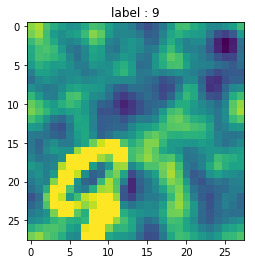

In [10]:
i = 3
plt.imshow(data[i,:,:].detach().numpy().reshape((28, 28)))
plt.title('label : '+str(label[i].item()))

## Affichage Image 128x128

In [11]:
import sys
sys.path.append("../figures")

from where_copie import RetinaFill, RetinaBackground, RetinaMask, RetinaWhiten 

In [12]:
i_offset = None
j_offset = None

In [13]:
from display import minmax

class WhereShift:
    def __init__(self, args, i_offset=None, j_offset=None, radius=None, theta=None, baseline=0., keep_label = False):
        self.args = args
        self.i_offset = i_offset
        self.j_offset = j_offset
        self.radius = radius
        self.theta = theta
        self.baseline = baseline
        self.keep_label = keep_label

    def __call__(self, data):
        #sample = np.array(sample)
        
        sample = data[0]
        seed = data[1]
        if self.keep_label:
            label = data[2]
        
        #print(index)
        np.random.seed(seed)
        
        if self.i_offset is not None:
            i_offset = self.i_offset
            if self.j_offset is None:
                #j_offset_f = np.random.randn() * self.args.offset_std
                #j_offset_f = minmax(j_offset_f, self.args.offset_max)
                #j_offset = int(j_offset_f)
                j_offset = np.random.randint(- self.args.N_pic //3, self.args.N_pic //3)
            else:
                j_offset = int(self.j_offset)
        else: 
            if self.j_offset is not None:
                j_offset = int(self.j_offset)
                #i_offset_f = np.random.randn() * self.args.offset_std
                #i_offset_f = minmax(i_offset_f, self.args.offset_max)
                #i_offset = int(i_offset_f)
                i_offset = np.random.randint( - self.args.N_pic //3, self.args.N_pic //3)
            else: #self.i_offset is None and self.j_offset is None
                i_offset = np.random.randint( - self.args.N_pic //3, self.args.N_pic //3)
                j_offset = np.random.randint( - self.args.N_pic //3, self.args.N_pic //3)
                """
                if self.theta is None:
                    theta = np.random.rand() * 2 * np.pi
                    #print(theta)
                else:
                    theta = self.theta
                if self.radius is None:
                    radius_f = np.abs(np.random.randn()) * self.args.offset_std
                    radius = minmax(radius_f, self.args.offset_max)
                    #print(radius)
                else:
                    radius = self.radius
                i_offset = int(radius * np.cos(theta))
                j_offset = int(radius * np.sin(theta))
                """
                
        #print("i_offset = ", i_offset)
        #print("j_offset = ", j_offset)
                
        N_pic = sample.shape[0]
        fullfield = np.ones((N_pic, N_pic)) * self.baseline
        i_binf_patch = max(0, -i_offset)
        i_bsup_patch = min(N_pic, N_pic - i_offset)
        j_binf_patch = max(0, -j_offset)
        j_bsup_patch = min(N_pic, N_pic - j_offset)
        patch = sample[i_binf_patch:i_bsup_patch,
                       j_binf_patch:j_bsup_patch]

        i_binf_data = max(0, i_offset)
        i_bsup_data = min(N_pic, N_pic + i_offset)
        j_binf_data = max(0, j_offset)
        j_bsup_data = min(N_pic, N_pic + j_offset)
        fullfield[i_binf_data:i_bsup_data,
                  j_binf_data:j_bsup_data] = patch
        if self.keep_label:
            return fullfield, label, i_offset, j_offset
        else:
            return fullfield #.astype('B')

In [14]:
transform=transforms.Compose([
                               RetinaFill(N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4), 
                               #WhereShift(args, radius = 18), 
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset),
                               RetinaBackground( contrast=args.contrast,
                                                 noise=args.noise,
                                                 sf_0=args.sf_0,
                                                 B_sf=args.B_sf),
                               RetinaMask(N_pic=args.N_pic),
                               #RetinaWhiten(N_pic=args.N_pic),
                                #OnlineRetinaTransform(retina) # ç décommenter une fois que le code sera mieux écrit
                               #RetinaTransform(retina.retina_transform_vector),
                               #Normalize()
                           ])

In [15]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        #target_transform = target_transform,
                        )

In [16]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [17]:
data3, label3 = next(iter(test_loader))

In [18]:
print(data3.shape)
label3.shape

torch.Size([100, 128, 128])


torch.Size([100])

shape torch.Size([100, 128, 128])


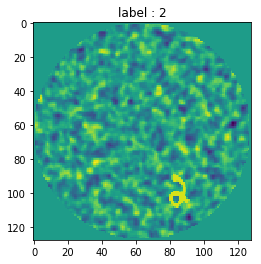

In [19]:
index_image=7
plt.imshow(data3[index_image])
print('shape',data3[:,:].shape)
plt.title('label : '+str(label3[index_image].item()))

if False :
    plt.savefig("image128x128")

In [20]:
#plt.plot(data3[i].detach().numpy())
#plt.plot(data3[i,:,:])
print(data3[index_image])

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       dtype=torch.float64)


## Essai ajouts repères

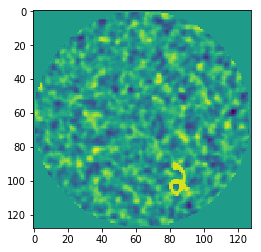

In [21]:
pixel_fullfield = data3[index_image]
plt.imshow(pixel_fullfield)
#plt.imshow(pixel_fullfield[0:50,0:50])

0.7770922496500585
1.0957000720065824
1.5449371015292812
2.178361313156287
3.0714894515503643
4.330800126686012
6.106428178627277
8.610063731864463
12.140189861928889
17.117667705319736


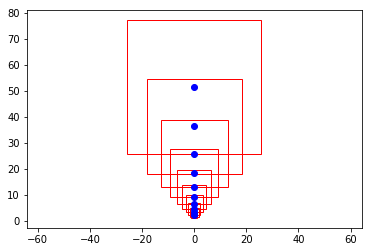

In [22]:
import matplotlib.patches as patches

ecc_max = 0.8
N_X, N_Y = 128, 128

Essai_r = []

fig, ax = plt.subplots()
for i_eccentricity in range(args.N_eccentricity):   
    Essai_ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    Essai_r.append(np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * Essai_ecc)  # radius

ax.plot([0]*10,Essai_r,'o', color='b')
    
    
for i in range(len(Essai_r)) :
    #rect = patches.Rectangle((-Essai_r[i]**(1/2)/2, Essai_r[i]-Essai_r[i]**(1/2)/2),Essai_r[i]**(1/2),Essai_r[i]**(1/2),linewidth=1,edgecolor='r',facecolor='none')
    rect = patches.Rectangle((-Essai_r[i]/2, Essai_r[i]-Essai_r[i]/2),Essai_r[i],Essai_r[i],linewidth=1,edgecolor='r',facecolor='none')
    #rect = patches.Rectangle((-Essai_r[i]/6, Essai_r[i]-Essai_r[i]/6),Essai_r[i]/3,Essai_r[i]/3,linewidth=1,edgecolor='r',facecolor='none')
    print(Essai_r[i]/3)
    ax.add_patch(rect)

ax.set_xlim((-5, 15))
ax.set_ylim((0, 10))
plt.axis("equal")
plt.show()

## Différentes méthodes de vectorisation

In [23]:
import matplotlib.patches as patches
from display import pe

# code original au self pres

def online_vectorization(pixel_fullfield):   # pixel_fullfield = image
        fullfield_dot_filters = np.zeros(args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase)

        from LogGabor import LogGabor
        lg = LogGabor(pe=pe)
        lg.set_size((args.N_pic, args.N_pic))
        
        indice = 0
        for i_theta in range(args.N_theta):
            for i_azimuth in range(args.N_azimuth):
                for i_eccentricity in range(args.N_eccentricity):
                    for i_phase in range(args.N_phase):
                        filter = local_filter(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic,
                                                  N_Y=args.N_pic)
                        fullfield_dot_filters[indice] = np.dot(np.ravel(filter), np.ravel(pixel_fullfield))
                        indice += 1

        return fullfield_dot_filters

In [24]:
import matplotlib.patches as patches
from display import pe

## Completion image avec des zeros

def online_vectorization_zeros(pixel_fullfield):   # pixel_fullfield = image # on enleve self pour l'instant
    fullfield_dot_filters = np.zeros(args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase)

    from LogGabor import LogGabor
    lg = LogGabor(pe=pe)
    
    indice = 0
    for i_theta in range(args.N_theta):
        for i_azimuth in range(args.N_azimuth):
            for i_eccentricity in range(args.N_eccentricity):
                for i_phase in range(args.N_phase):
                    filter, size, x, y, r = local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic,
                                              N_Y=args.N_pic)
                    #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                        #print(filter.shape)
                        #fig, ax = plt.subplots()
                        #plt.imshow(filter)
                        #plt.title("filtre")
                        #rect = patches.Rectangle((args.N_pic//2-r, args.N_pic//2-r), 2*r, 2*r,linewidth=3,edgecolor='r',facecolor='none')
                        #ax.add_patch(rect)
                        #plt.show()
                    #print("taille et positions filtre",size,x,y)
                    fenetre_filtre = filter[int(args.N_pic//2-r):int(args.N_pic//2+r),int(args.N_pic//2-r):int(args.N_pic//2+r)]
                    #print("filter", np.ravel(fenetre_filtre).shape)
                    
                    if size%2 ==0 :
                        #print(x-size/2,y-size/2)
                        #print("x,y,r",x,y,r)
                        #print(int(x-r),int(x+r),int(y-r),int(y+r))
                        fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]
                        #print("image1", np.ravel(fenetre_image).shape)
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image)
                            #plt.title("image1")
                            #plt.show()
                        if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                            #print("tailles differentes")
                            complement = [0]*(np.ravel(fenetre_filtre).shape[0] - np.ravel(fenetre_image).shape[0])
                            #print("extrait filtre", fenetre_filtre[0:20])
                            #print("extrait image", fenetre_image[0:20])
                            #print("extrait complement", complement[0:20])
                            fenetre_image = np.concatenate((np.ravel(fenetre_image), complement))
                            #print("image1", np.ravel(fenetre_image).shape)
                        a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                        #a=0
                        fullfield_dot_filters[indice] = a
                        
                    else :
                        fenetre_image2 = pixel_fullfield[x-int(r)-1:x+int(r),y-int(r)-1:y+int(r)]
                        #print("image2", np.ravel(fenetre_image2).shape)
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image2)
                            #plt.title("image2")
                            #plt.show()
                        if np.ravel(fenetre_image2).shape != np.ravel(fenetre_filtre).shape :
                            complement = [0]*(np.ravel(fenetre_filtre).shape[0] - np.ravel(fenetre_image).shape[0])
                            fenetre_image = np.concatenate((np.ravel(fenetre_image), complement))                            
                        b = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image2))
                        #b=0
                        fullfield_dot_filters[indice] = b
                    
                    indice += 1
                    #print("\n")

    return fullfield_dot_filters

In [25]:
import matplotlib.patches as patches
from display import pe

## Completion image avec des vraies valeurs, damier 3x3


def online_vectorizationV(pixel_fullfield):   # pixel_fullfield = image # on enleve self pour l'instant
    fullfield_dot_filters = np.zeros(args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase)

    from LogGabor import LogGabor
    lg = LogGabor(pe=pe)
    
    indice = 0 
    for i_theta in range(args.N_theta):
        for i_azimuth in range(args.N_azimuth):
            for i_eccentricity in range(args.N_eccentricity):
                for i_phase in range(args.N_phase):
                    filter, size, x, y, r = local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic,
                                              N_Y=args.N_pic)
                    #r = min(2*r, 128)
                    r = min(2*r, 64)
                    #r = min(3*r, 64)
                    #print(r)
                    #print("filter", np.ravel(filter).shape)
                    filter -= np.mean(filter)
                    if True and i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                        print(filter.shape)
                        fig, ax = plt.subplots()
                        plt.imshow(filter)
                        plt.title("filtre")
                        rect = patches.Rectangle((args.N_pic//2-r, args.N_pic//2-r), 2*r, 2*r,linewidth=3,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)
                        plt.show()
                    #print("taille et positions filtre",size,x,y)
                    fenetre_filtre = filter[int(args.N_pic//2-r):int(args.N_pic//2+r),int(args.N_pic//2-r):int(args.N_pic//2+r)]
                    #print("fenetre filter", np.ravel(fenetre_filtre).shape)
                    #print("len fenetre filter", int(args.N_pic//2-r)-int(args.N_pic//2+r), int(args.N_pic//2-r)-int(args.N_pic//2+r))
                    
                    
                    if size%2 ==0 :
                        #print(x-size/2,y-size/2)
                        #print("x,y,r",x,y,r)
                        #print(int(x-r),int(x+r),int(y-r),int(y+r))
                        fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]
                        #print("fenetre image1", np.ravel(fenetre_image).shape)
                        #print("len fenetre image1", int(x-r)-int(x+r), int(y-r)-int(y+r))
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image)
                            #plt.title("image1")
                            #plt.show()
                        if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                            #print("tailles differentes")
                            image_agrandie = np.zeros((3*args.N_pic,3*args.N_pic))
                            for i in range(3):
                                for j in range(3):
                                    image_agrandie[i*args.N_pic : (i+1)*args.N_pic , j*args.N_pic : (j+1)*args.N_pic] = pixel_fullfield
                            #plt.imshow(image_agrandie)
                            #plt.title("image agrandie")
                            #plt.show()
                            fenetre_image = image_agrandie[int(args.N_pic + x-r) : int(args.N_pic+ x+r), int(args.N_pic +y-r) : int(args.N_pic +y+r)]
                            #plt.imshow(fenetre_image)
                            #plt.title("fenetre_redimensionnee")
                            #plt.show()
                            #print("filter", np.ravel(fenetre_filtre).shape)
                            #print("fenetre image", np.ravel(fenetre_image).shape)
                            #print("x,y,r",x,y,r)
                        #print("i_theta, i_azimuth, i_eccentricity, i_phase", i_theta, i_azimuth, i_eccentricity, i_phase)
                        a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                        #a=0
                        fullfield_dot_filters[indice] = a
                        
                    else :
                        fenetre_image2 = pixel_fullfield[int(x-r-1):int(x+r),int(y-r-1):int(y+r)]
                        #print("image2", np.ravel(fenetre_image2).shape)
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image2)
                            #plt.title("image2")
                            #plt.show()
                        if np.ravel(fenetre_image2).shape != np.ravel(fenetre_filtre).shape :
                            image_agrandie = np.zeros((3*args.N_pic,3*args.N_pic))
                            #print("image agrandie")
                            for i in range(3):
                                for j in range(3):
                                    image_agrandie[i*args.N_pic : (i+1)*args.N_pic , j*args.N_pic : (j+1)*args.N_pic] = pixel_fullfield
                            fenetre_image2 = image_agrandie[int(args.N_pic + x-r) : int(args.N_pic+ x+r), int(args.N_pic + y-r) : int(args.N_pic + y+r)]                              
                        #print("filter", np.ravel(fenetre_filtre).shape)
                        #print("fenetre image2", np.ravel(fenetre_image2).shape)
                        #print("x,y,r",x,y,r)
                        b = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image2))
                        #b=0
                        fullfield_dot_filters[indice] = b
                    indice += 1
                    
                    
                    #print("\n")

    return fullfield_dot_filters

In [26]:
import matplotlib.patches as patches
from display import pe

## Completion image avec des vraies valeurs, "modulo"

def affiche(donnees, titre, c_a, commentaire=None):
    if c_a :
        if commentaire :
            print(commentaire)
        plt.imshow(donnees)
        plt.title(titre)           
        plt.show()

def affiche_filtre(donnees, titre, c_a, r):
    if c_a :
        fig, ax = plt.subplots()
        plt.imshow(donnees)
        plt.title(titre)        
        rect = patches.Rectangle((args.N_pic//2-r, args.N_pic//2-r), 2*r, 2*r,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)            
        plt.show()

def online_vectorizationVm(pixel_fullfield):   # pixel_fullfield = image # on enleve self pour l'instant
    fullfield_dot_filters = np.zeros(args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase)

    from LogGabor import LogGabor
    lg = LogGabor(pe=pe)
        
    indice = 0 
    for i_theta in range(args.N_theta):
        for i_azimuth in range(args.N_azimuth):
            for i_eccentricity in range(args.N_eccentricity):
                for i_phase in range(args.N_phase):
                    filter, size, x, y, r = local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic,
                                              N_Y=args.N_pic)
                    
                    c_a = i_azimuth == 16 and i_theta == 0 and i_phase == 0 # conditions d'affichage
                    #c_a = False
                    #print("conditions", c_a)
                    
                    r = min(int(2*r), 64)
                    #r = min(int(3*r), 64)

                    #filter -= np.mean(filter)
                    affiche_filtre(filter, "filtre", c_a, r)
                    
                    fenetre_filtre = filter[int(args.N_pic//2-r):int(args.N_pic//2+r),int(args.N_pic//2-r):int(args.N_pic//2+r)]
                    fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]
                    #print("taille fenetre filtre", fenetre_filtre.shape)

                    if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                        fenetre_image = np.zeros((2*r,2*r))

                        
                        if y + r > args.N_pic : # ca depasse à droite
                            morceau_interne_fullfield = pixel_fullfield[x-r:x+r, y-r:args.N_pic]
                            morceau_externe_fullfield = pixel_fullfield[x-r:x+r, 0:y+r-args.N_pic] # qu'on est donc alle chercher ailleurs dans l'image
                            nb_lignes = morceau_externe_fullfield.shape[0]
                            if nb_lignes == 2*r : # ce n'est pas un coin
                                fenetre_image[0:2*r, 0:r+args.N_pic-y] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                                fenetre_image[0:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)

                            elif x - r < 0 : # contient le coin superieur droit
                                morceau_externe_fullfield = pixel_fullfield[0:x+r, 0:r-args.N_pic+y]
                                fenetre_image[r-x:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction image : ajout bas droit", c_a)
                                fenetre_image[0:r-x, r-y+args.N_pic:2*r] = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r-args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)

                            elif x + r > args.N_pic : # contient le coin inferieur droit
                                fenetre_image[0:nb_lignes, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                                fenetre_image[r-x+args.N_pic:2*r, r-y+args.N_pic:2*r] = pixel_fullfield[0:x+r-args.N_pic, 0:y+r-args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)
               
                
                        elif y - r < 0 : # ca depasse a gauche
                            morceau_externe_fullfield = pixel_fullfield[x-r:x+r, args.N_pic-r+y:args.N_pic]
                            morceau_interne_fullfield = pixel_fullfield[x-r:x+r, 0:y+r]
                            nb_lignes = morceau_externe_fullfield.shape[0]
                            if nb_lignes == 2*r : # ce n'est pas un coin
                                fenetre_image[0:2*r, 0:r-y] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                                fenetre_image[0:2*r, r-y:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)
                                
                            elif x - r < 0 : # contient le coin superieur gauche
                                morceau_externe_fullfield = pixel_fullfield[0:x+r, args.N_pic-r+y:args.N_pic]
                                fenetre_image[r-x:2*r, 0:r-y] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                                fenetre_image[0:r-x, 0:r-y] = pixel_fullfield[args.N_pic-r+x:args.N_pic, args.N_pic-r+y:args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)

                            elif x + r > args.N_pic : # contient le coin inferieur gauche
                                fenetre_image[r+args.N_pic-x:2*r, 0:r-y] = pixel_fullfield[0:x+r-args.N_pic, args.N_pic-r+y:args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                                fenetre_image[0:r+args.N_pic-x, 0:r-y] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a) 

                            
                        if x - r < 0 : # ca depasse en haut
                            morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, y-r:y+r]
                            morceau_interne_fullfield = pixel_fullfield[0:r+x, y-r:y+r]
                            nb_colonnes = morceau_externe_fullfield.shape[1]
                            if nb_colonnes == 2*r : # ce n'est pas un coin
                                fenetre_image[r-x:2*r, 0:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)
                                fenetre_image[0:r-x, 0:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)

                            elif y - r < 0 : # contient le coin superieur gauche
                                morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r]
                                morceau_interne_fullfield = pixel_fullfield[0:r+x, 0:y+r]
                                fenetre_image[0:r-x, r-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                                fenetre_image[r-x:2*r, r-y:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                            elif y + r > args.N_pic : # contient le coin superieur droit
                                nb_colonnes = r + args.N_pic - y 
                                fenetre_image[0:r-x, 0:nb_colonnes] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                                fenetre_image[r-x:2*r, 0:nb_colonnes] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                            

                        elif x + r > args.N_pic : # ca depasse en bas
                            morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, y-r:y+r]
                            morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, y-r:y+r]
                            nb_colonnes = morceau_externe_fullfield.shape[1]
                            if nb_colonnes == 2*r : # ce n'est pas un coin                               
                                fenetre_image[0:args.N_pic-x+r, 0:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)
                                fenetre_image[args.N_pic-x+r:2*r, 0:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)

                            elif y - r < 0 : # contient le coin inferieur gauche
                                morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, 0:r+y]
                                morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, 0:r+y]
                                fenetre_image[0:args.N_pic-x+r, r-y:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                                fenetre_image[args.N_pic-x+r:2*r, r-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                            elif y + r > args.N_pic : # contient le coin inferieur droit
                                fenetre_image[0:args.N_pic-x+r, 0:nb_colonnes] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                                fenetre_image[args.N_pic-x+r:2*r, 0:nb_colonnes] = morceau_externe_fullfield 
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                            
                    
                    affiche(fenetre_image, "image correspondant au filtre ci-dessus", c_a) 
                        
                    a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                    fullfield_dot_filters[indice] = a
                    
                    indice += 1

    return fullfield_dot_filters

                                                                 
print("hello")


hello


## Définition originale et légèrement modifiée de local filter

In [27]:
## code original au self pres

def local_filter(i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                 N_X=128, N_Y=128):
                 #rho=1.41, ecc_max=.8,
                 #sf_0_max=0.45, sf_0_r=0.03,
                 #B_sf=.4, B_theta=np.pi / 12):

    # !!?? Magic numbers !!??
    ecc_max = .8 # self.args.ecc_max
    sf_0_r = 0.03 # self.args.sf_0_r
    B_theta = np.pi/args.N_theta/2 #self.args.B_theta
    B_sf = .4
    sf_0_max = 0.45

    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi)
    y = N_Y / 2 + r * np.sin(psi)
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    return lg.normalize(lg.invert(lg.loggabor(x, y, **params) * np.exp(-1j * phase))).ravel()


In [28]:
def local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                 N_X=128, N_Y=128):
                 #rho=1.41, ecc_max=.8,
                 #sf_0_max=0.45, sf_0_r=0.03,
                 #B_sf=.4, B_theta=np.pi / 12): # on enleve self pour l'instant

    # !!?? Magic numbers !!??
    ecc_max = .8 # self.args.ecc_max
    sf_0_r = 0.03 # self.args.sf_0_r
    B_theta = np.pi/args.N_theta/2 #self.args.B_theta
    B_sf = .4
    sf_0_max = 0.45

    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    #print(r)
    size = int(2*r)
    if size < 2 :
        size = 2    
    #print("size",size)
    #lg.set_size((size, size))
    lg.set_size((N_X, N_Y))
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi) # c'est bien le centre du filtre ?
    y = N_Y / 2 + r * np.sin(psi) # c'est bien le centre du filtre ?
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    #lg.show_loggabor(x, y, **params)
    #print('taille sortie', lg.loggabor(x, y, **params).ravel().shape)
    return lg.normalize(lg.invert(lg.loggabor(N_X//2, N_Y//2, **params) * np.exp(-1j * phase))), size, int(x), int(y), r

## Exécution et comparaison des différents codes

In [29]:
fullfield_dot_filters = online_vectorization(pixel_fullfield)
fullfield_dot_filters0 = online_vectorization_zeros(pixel_fullfield)

(128, 128)


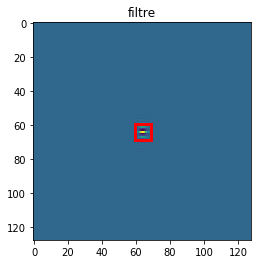

(128, 128)


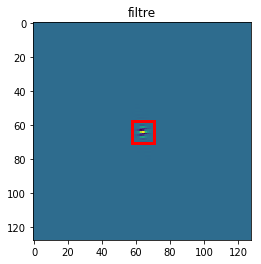

(128, 128)


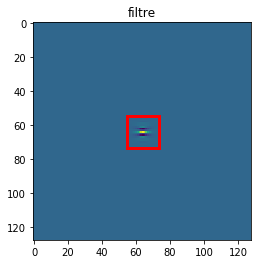

(128, 128)


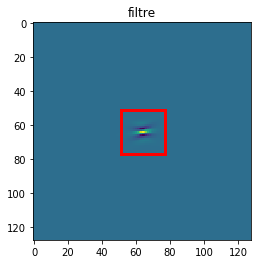

(128, 128)


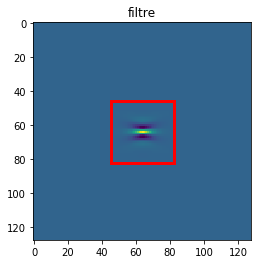

(128, 128)


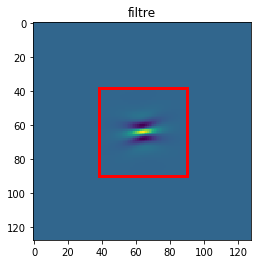

(128, 128)


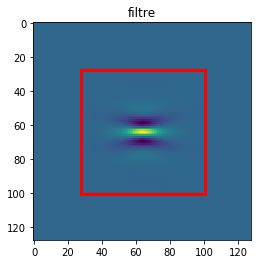

(128, 128)


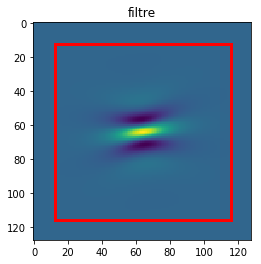

(128, 128)


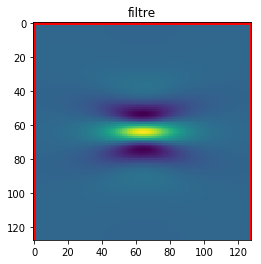

(128, 128)


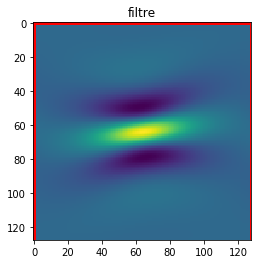

In [30]:
fullfield_dot_filtersV = online_vectorizationV(pixel_fullfield)

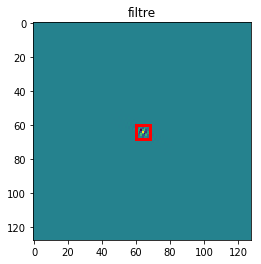

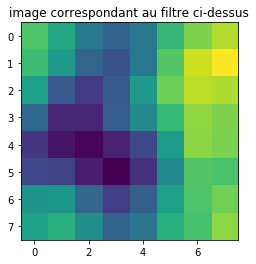

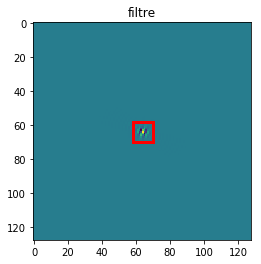

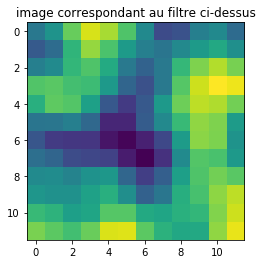

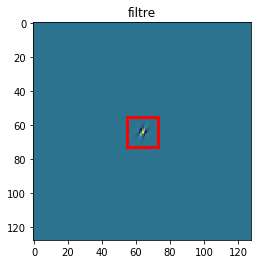

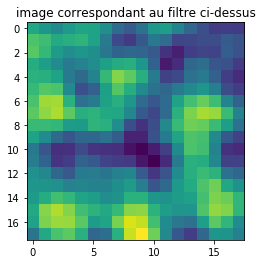

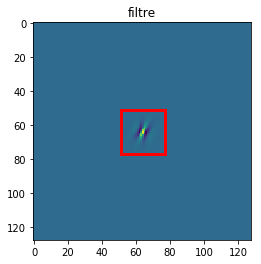

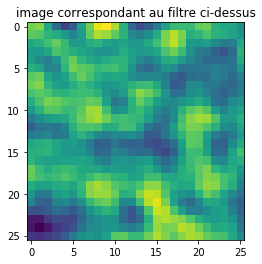

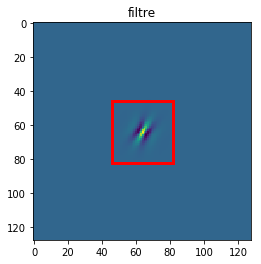

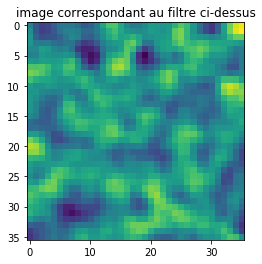

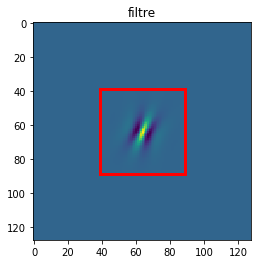

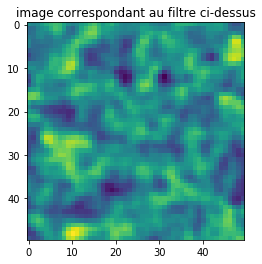

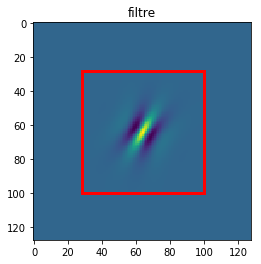

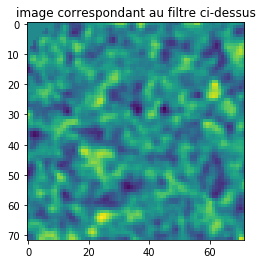

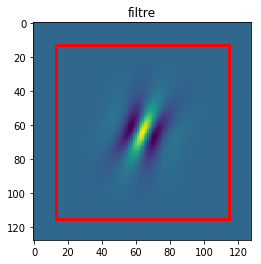

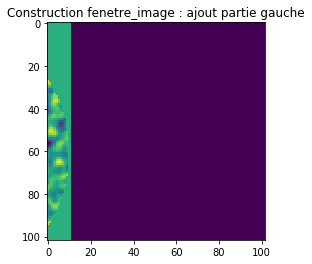

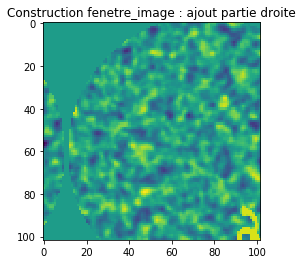

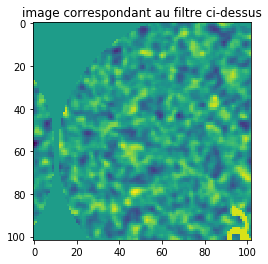

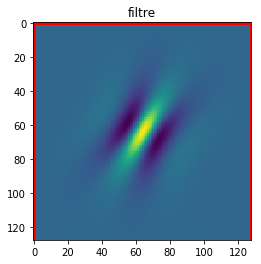

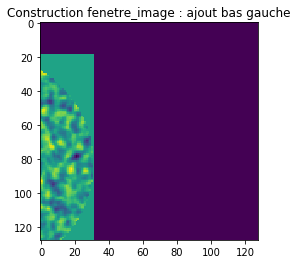

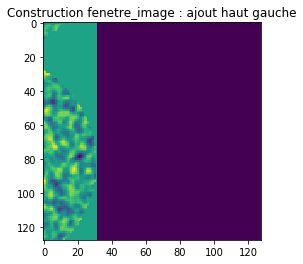

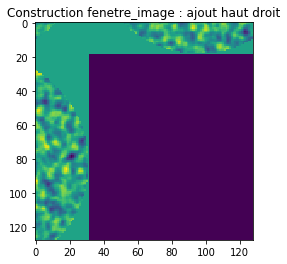

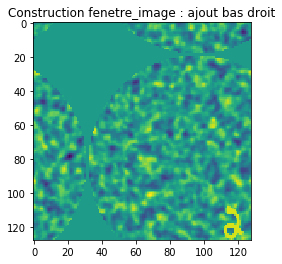

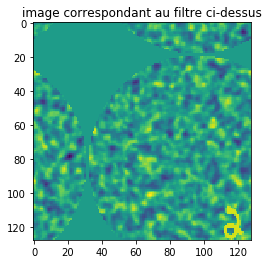

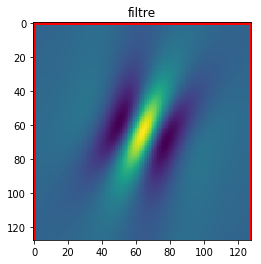

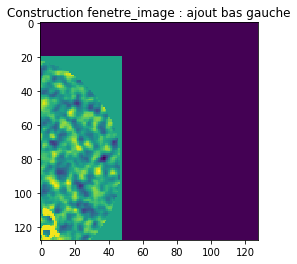

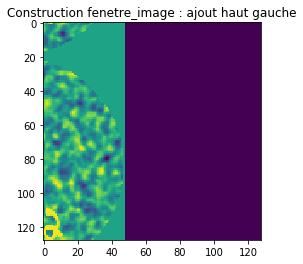

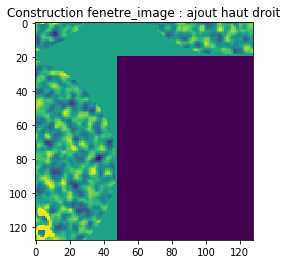

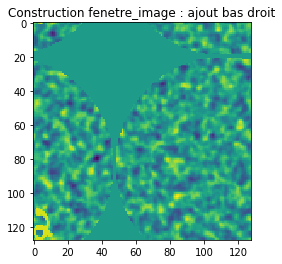

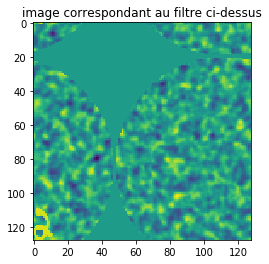

In [31]:
fullfield_dot_filtersVm = online_vectorizationVm(pixel_fullfield)

In [32]:
diff = 0
for i in range(2880):
    diff += abs(fullfield_dot_filtersV[i] - fullfield_dot_filtersVm[i])
    #if i%10 ==0 : print(i,abs(fullfield_dot_filters[i] - fullfield_dot_filtersVm[i]))
print(diff)

29.72185079716595


In [33]:
diff = 0
for i in range(2880):
    diff += abs(fullfield_dot_filters[i] - fullfield_dot_filtersVm[i])
    #if i%10 ==0 : print(i,abs(fullfield_dot_filters[i] - fullfield_dot_filtersVm[i]))
print(diff)

1316.0535936192425


In [34]:
diff = 0
for i in range(2880):
    diff += abs(fullfield_dot_filters[i] - fullfield_dot_filtersV[i])
    #if i%10 ==0 : print(i,abs(fullfield_dot_filters[i] - fullfield_dot_filtersV[i]))
print(diff)

1324.653232225157


(-25, 25)

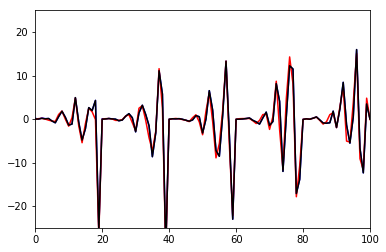

In [35]:
#plt.plot(fullfield_dot_filters0, 'g')
plt.plot(fullfield_dot_filtersV, 'b')
plt.plot(fullfield_dot_filters,'r')
plt.plot(fullfield_dot_filtersVm, 'black')

axes = plt.gca()
axes.set_xlim(0,100)
axes.set_ylim(-25,25)

## Zone expérimentale

In [36]:
if False :
    import numpy as np
    import matplotlib.pyplot as plt

    #import SLIP for whitening and PIL for resizing
    import SLIP
    from display import pe

    ##########################################################################################################@
    ##########################################################################################################@
    ##########################################################################################################@

    class Retina:
        """ Class implementing the retina transform
        """
        def __init__(self, args):

            self.args = args

            self.N_pic = args.N_pic
            self.whit = SLIP.Image(pe=pe)
            self.whit.set_size((self.N_pic, self.N_pic))
            # https://github.com/bicv/SLIP/blob/master/SLIP/SLIP.py#L611
            self.K_whitening = self.whit.whitening_filt()

            self.N_theta = args.N_theta
            self.N_azimuth = args.N_azimuth
            self.N_eccentricity = args.N_eccentricity
            self.N_phase = args.N_phase
            self.feature_vector_size = self.N_theta * self.N_azimuth * self.N_eccentricity * self.N_phase
            self.retina_dico = {}

            self.init_grid()
            self.init_retina_transform()
            self.init_inverse_retina()
            self.init_colliculus_transform()
            self.init_colliculus_inverse()
            self.init_retina_dico()


        def init_grid(self):
            delta = 1. / self.N_azimuth
            self.log_r_grid, self.theta_grid = \
            np.meshgrid(np.linspace(0, 1, self.N_eccentricity + 1),
                        np.linspace(-np.pi * (.5 + delta), np.pi * (1.5 - delta), self.N_azimuth + 1))

        def get_suffix(self):
            # suffix = f'_{self.N_theta}_{self.N_azimuth}'
            # suffix += f'_{self.N_eccentricity}_{self.N_phase}'
            # suffix += f'_{self.args.rho}_{self.N_pic}'

            suffix = '_{}_{}'.format(self.N_theta, self.N_azimuth)
            suffix += '_{}_{}'.format(self.N_eccentricity, self.N_phase)
            suffix += '_{}_{}'.format(self.args.rho, self.N_pic)
            return suffix

        def init_retina_transform(self):
            filename = '../tmp/retina' + self.get_suffix() + '_transform.npy'
            print(filename)
            try:
                self.retina_transform = np.load(filename)
                print("Fichier retina_transform charge avec succes")
            except:
                if self.args.verbose: print('Retina vectorizing...')
                self.retina_transform = self.vectorization()
                print("ok")
                np.save(filename, self.retina_transform)
                print("Fichier retina_transform ecrit et sauvegarde avec succes")
                if self.args.verbose: print('Done vectorizing...')
            self.retina_transform_vector = self.retina_transform.reshape((self.feature_vector_size, self.N_pic ** 2))

        def init_inverse_retina(self):
            filename = '../tmp/retina' + self.get_suffix() + '_inverse_transform.npy'
            try:
                self.retina_inverse_transform = np.load(filename)
                print("Fichier retina_inverse_transform charge avec succes")
            except:
                if self.args.verbose: print('Inversing retina transform...')
                self.retina_inverse_transform = np.linalg.pinv(self.retina_transform_vector)
                print("ok2")
                np.save(filename, self.retina_inverse_transform)
                print("Fichier retina_inverse_transform ecrit et suavegarde avec succes")
                if self.args.verbose: print('Done Inversing retina transform...')

        def init_colliculus_transform(self):
            # TODO : make a different transformation for the clliculus (more eccentricties?)
            self.colliculus_transform = (self.retina_transform ** 2).sum(axis=(0, 3))
            # colliculus = colliculus**.5
            self.colliculus_transform /= self.colliculus_transform.sum(axis=-1)[:, :, None]  # normalization as a probability
            self.colliculus_transform_vector = self.colliculus_transform.reshape((self.N_azimuth * self.N_eccentricity, self.N_pic ** 2))

        def init_colliculus_inverse(self):
            self.colliculus_inverse = np.linalg.pinv(self.colliculus_transform_vector)


        def init_retina_dico(self):
            print("Creation du dictionnaire de filtres en cours")
            for i_theta in self.N_theta :
                self.retina_dico[i_theta] = {}
                for i_phase in self.N_phase :
                    self.retina_dico[i_theta][i_phase] = {}
                    for i_eccentricity in self.N_eccentricity :
                        self.retina_dico[i_theta][i_phase][i_eccentricity] = self.local_filter3(self, i_theta, i_eccentricity, i_phase, lg, N_X=128, N_Y = 128)
            print("Dico cree")

        def vectorization(self):
            #N_theta=6, N_azimuth=16, N_eccentricity=10, N_phase=2,
            #              N_X=128, N_Y=128, rho=1.41, ecc_max=.8, sf_0_max=0.45, sf_0_r=0.03, B_sf=.4, B_theta=np.pi / 12):

            retina = np.zeros((self.N_theta, self.N_azimuth, self.N_eccentricity, self.N_phase, self.N_pic**2))

            from LogGabor import LogGabor
            lg = LogGabor(pe=pe)
            lg.set_size((self.N_pic, self.N_pic))

            for i_theta in range(self.N_theta):
                for i_azimuth in range(self.N_azimuth):
                    for i_eccentricity in range(self.N_eccentricity):
                        for i_phase in range(self.N_phase):
                            retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = self.local_filter(i_theta,
                                                                                                  i_azimuth,
                                                                                                  i_eccentricity,
                                                                                                  i_phase,
                                                                                                  lg,
                                                                                                  N_X=self.N_pic,
                                                                                                  N_Y=self.N_pic)
                                                                                                  #rho=self.args.rho,
                                                                                                  #ecc_max=self.args.ecc_max,
                                                                                                  #sf_0_max=self.args.sf_0_max,
                                                                                                  #sf_0_r=self.args.sf_0_r,
                                                                                                  #B_sf=self.args.B_sf,
                                                                                                  #B_theta=self.args.B_theta)

            return retina

        def online_vectorization(self, pixel_fullfield):   # pixel_fullfield = image
            fullfield_dot_filters = np.zeros(self.N_theta * self.N_azimuth * self.N_eccentricity * self.N_phase)

            from LogGabor import LogGabor
            lg = LogGabor(pe=pe)
            lg.set_size((self.N_pic, self.N_pic))

            for i_theta in range(self.N_theta):
                for i_azimuth in range(self.N_azimuth):
                    for i_eccentricity in range(self.N_eccentricity):
                        for i_phase in range(self.N_phase):
                            filter = self.local_filter(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=self.N_pic,
                                                      N_Y=self.N_pic)
                            indice = i_theta + i_azimuth + i_eccentricity + i_phase
                            fullfield_dot_filters[indice] = np.dot(np.ravel(filter), np.ravel(pixel_fullfield))

            return fullfield_dot_filters





        def local_filter(self, i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                         N_X=128, N_Y=128):
                         #rho=1.41, ecc_max=.8,
                         #sf_0_max=0.45, sf_0_r=0.03,
                         #B_sf=.4, B_theta=np.pi / 12):

            # !!?? Magic numbers !!??
            ecc_max = .8 # self.args.ecc_max
            sf_0_r = 0.03 # self.args.sf_0_r
            B_theta = np.pi/self.N_theta/2 #self.args.B_theta
            B_sf = .4
            sf_0_max = 0.45

            ecc = ecc_max * (1 / self.args.rho) ** (self.N_eccentricity - i_eccentricity)
            r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
            # psi = i_azimuth * np.pi * 2 / N_azimuth
            psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / self.N_azimuth
            theta_ref = i_theta * np.pi / self.N_theta
            sf_0 = 0.5 * sf_0_r / ecc
            sf_0 = np.min((sf_0, sf_0_max))
            # TODO : find the good ref for this                print(sf_0)
            x = N_X / 2 + r * np.cos(psi)
            y = N_Y / 2 + r * np.sin(psi)
            params = {'sf_0': sf_0,
                      'B_sf': B_sf,
                      'theta': theta_ref + psi,
                      'B_theta': B_theta}
            phase = i_phase * np.pi / 2
            return lg.normalize(lg.invert(lg.loggabor(x, y, **params) * np.exp(-1j * phase))).ravel()

        def local_filter3(self, i_theta, i_eccentricity, i_phase, lg,
                         N_X=128, N_Y=128):
                         #rho=1.41, ecc_max=.8,
                         #sf_0_max=0.45, sf_0_r=0.03,
                         #B_sf=.4, B_theta=np.pi / 12):

            # !!?? Magic numbers !!??
            ecc_max = .8 # self.args.ecc_max
            sf_0_r = 0.03 # self.args.sf_0_r
            B_theta = np.pi/self.N_theta/2 #self.args.B_theta
            B_sf = .4
            sf_0_max = 0.45

            ecc = ecc_max * (1 / self.args.rho) ** (self.N_eccentricity - i_eccentricity)
            r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
            theta_ref = i_theta * np.pi / self.N_theta
            sf_0 = 0.5 * sf_0_r / ecc
            sf_0 = np.min((sf_0, sf_0_max))
            # TODO : find the good ref for this                print(sf_0)
            params = {'sf_0': sf_0,
                      'B_sf': B_sf,
                      'theta': theta_ref, # psi retire
                      'B_theta': B_theta}
            phase = i_phase * np.pi / 2
            return lg.normalize(lg.invert(lg.loggabor(0, 0, **params) * np.exp(-1j * phase))).ravel()


        def retina(self, data_fullfield):
            # https://github.com/bicv/SLIP/blob/master/SLIP/SLIP.py#L674
            # data_fullfield = self.whit.whitening(data_fullfield)
            # https://github.com/bicv/SLIP/blob/master/SLIP/SLIP.py#L518
            data_fullfield = self.whit.FTfilter(data_fullfield, self.K_whitening)
            data_retina = self.retina_transform_vector @ np.ravel(data_fullfield)
            return data_retina #retina(data_fullfield, self.retina_transform)     

        def dico_transform(self, data_fullfield):
            fullfield_dot_filters = np.zeros(self.N_theta * self.N_azimuth * self.N_eccentricity * self.N_phase)
            indice = 0
            for i_theta in range(self.N_theta):
                for i_azimuth in range(self.N_azimuth):
                    for i_eccentricity in range(self.N_eccentricity):
                        for i_phase in range(self.N_phase):
                            fullfield_dot_filters[indice] = 0
            data_retina = self.retina_transform_vector @ np.ravel(data_fullfield)
            return data_retina       


        def retina_invert(self, data_retina, do_dewhitening=False):
            im = self.retina_inverse_transform @ data_retina
            im = im.reshape((self.args.N_pic, self.args.N_pic))
            if do_dewhitening: im = self.whit.dewhitening(im)
            return im

        def accuracy_fullfield(self, accuracy_map, i_offset, j_offset):
            #accuracy_colliculus, accuracy_fullfield_map = accuracy_fullfield(accuracy_map, i_offset, j_offset, self.args.N_pic, self.colliculus_transform_vector)
            from display import do_offset
            accuracy_fullfield_map = do_offset(data=accuracy_map,
                                               i_offset=i_offset,
                                               j_offset=j_offset,
                                               N_pic=self.N_pic,
                                               data_min=0.1)
            accuracy_colliculus = self.colliculus_transform_vector @ accuracy_fullfield_map.ravel()
            return accuracy_colliculus, accuracy_fullfield_map

        def accuracy_invert(self, accuracy_colliculus):
            im = self.colliculus_inverse @ accuracy_colliculus

            return im.reshape(self.args.N_pic, self.args.N_pic)


        def show(self, ax, im, rmin=None, rmax=None, ms=26, markeredgewidth=1, alpha=.6, lw=.75, do_cross=True):
            if rmin is None: rmin = im.min()
            if rmax is None: rmax = im.max()
            ax.imshow(im, cmap=plt.viridis(), vmin=rmin, vmax=rmax)
            if do_cross:
                mid = self.args.N_pic//2
                w = self.args.w

                ax.plot([mid], [mid], '+g', ms=ms, markeredgewidth=markeredgewidth, alpha=alpha)

                ax.plot([mid-w/2, mid+w/2, mid+w/2, mid-w/2, mid-w/2], 
                        [mid-w/2, mid-w/2, mid+w/2, mid+w/2, mid-w/2], '--', color='r', lw=lw, markeredgewidth=1)

            ax.set_xticks([])
            ax.set_yticks([])
            return ax

    ######################

In [37]:
if False :
    N_theta=3
    N_azimuth=3
    N_eccentricity=3
    N_phase=2
    retina_dico ={}

    valeur = 50
    print("Creation du dictionnaire de filtres en cours")
    for i_theta in range(N_theta) :
        retina_dico[i_theta] = {}
        for i_phase in range(N_phase) :
            retina_dico[i_theta][i_phase] = {}
            for i_eccentricity in range(N_eccentricity) :
                valeur += 1
                retina_dico[i_theta][i_phase][i_eccentricity] = [[valeur,valeur],[valeur,valeur]]
    print("Dico cree")

    print(retina_dico)

    fullfield_dot_filters = np.zeros(N_theta * N_azimuth * N_eccentricity * N_phase)
    data_fullfield = np.random.randint(10, size=(2,2))

    
    print(data_fullfield)
    indice = 0
    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                for i_phase in range(N_phase):
                    #fullfield_dot_filters[indice] = np.ravel(retina_dico[i_theta][i_eccentricity][i_phase]) @ np.ravel(data_fullfield)
                    indice += 1                   
## les filtres ont des centres situés sur le demi axe horizontal positif.
## il va falloir les décaler au bon endroit de l'image


In [38]:
print( [2,2]*2)

[2, 2, 2, 2]


In [39]:
from display import pe
import matplotlib.patches as patches

from LogGabor import LogGabor
lg = LogGabor(pe=pe)
lg.set_size((args.N_pic, args.N_pic))

In [40]:
# a ne plus utiliser, cette fonction n'utilise pas azimuth alors que c'est necessaire pour orienter les filtres
if False :
    def local_filter3(i_theta, i_eccentricity, i_phase, lg,
                     N_X=128, N_Y=128):
                     #rho=1.41, ecc_max=.8,
                     #sf_0_max=0.45, sf_0_r=0.03,
                     #B_sf=.4, B_theta=np.pi / 12):
        lg.set_size((N_X, N_Y))
        # !!?? Magic numbers !!??
        ecc_max = .8 # self.args.ecc_max
        sf_0_r = 0.03 # self.args.sf_0_r
        B_theta = np.pi/args.N_theta/2 #self.args.B_theta
        B_sf = .4
        sf_0_max = 0.45
        #psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth # i_azimuth neccessaire
        ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
        theta_ref = i_theta * np.pi / args.N_theta
        sf_0 = 0.5 * sf_0_r / ecc
        sf_0 = np.min((sf_0, sf_0_max))
        # TODO : find the good ref for this                print(sf_0)
        params = {'sf_0': sf_0,
                  'B_sf': B_sf,
                  'theta': theta_ref, # psi retire
                  'B_theta': B_theta}
        phase = i_phase * np.pi / 2
        return lg.normalize(lg.invert(lg.loggabor(N_X//2, N_Y//2, **params) * np.exp(-1j * phase))).ravel() 
    # normalement, i_azimuth sert a calculer psi, qui sert a calculer 'theta' de params, qui est utilise dans le return

In [41]:
def local_filter4(i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                 N_X=128, N_Y=128):
                 #rho=1.41, ecc_max=.8,
                 #sf_0_max=0.45, sf_0_r=0.03,
                 #B_sf=.4, B_theta=np.pi / 12): # on enleve self pour l'instant

    lg.set_size((N_X, N_Y))
    # !!?? Magic numbers !!??
    ecc_max = .8 # self.args.ecc_max
    sf_0_r = 0.03 # self.args.sf_0_r
    B_theta = np.pi/args.N_theta/2 #self.args.B_theta
    B_sf = .4
    sf_0_max = 0.45

    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    #print(r)
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi) # c'est bien le centre du filtre ?
    y = N_Y / 2 + r * np.sin(psi) # c'est bien le centre du filtre ?
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    #lg.show_loggabor(x, y, **params)
    #print('taille sortie', lg.loggabor(x, y, **params).ravel().shape)
    return lg.normalize(lg.invert(lg.loggabor(N_X//2, N_Y//2, **params) * np.exp(-1j * phase)))

In [42]:
N_theta=args.N_theta
N_azimuth=args.N_azimuth
N_eccentricity=args.N_eccentricity
N_phase=args.N_phase
print(N_theta, N_azimuth, N_eccentricity, N_phase)

6 24 10 2


In [43]:
#Dico 3 entrees : ce n'est pas sufisant, azimuth est utilisé pour orienter chaque filtre

if False :
    print("Creation du dictionnaire de filtres en cours")
    retina_dico ={}
    for i_theta in range(N_theta) :
        retina_dico[i_theta] = {}
        for i_phase in range(N_phase) :
            retina_dico[i_theta][i_phase] = {}
            for i_eccentricity in range(N_eccentricity) :
                retina_dico[i_theta][i_phase][i_eccentricity] = local_filter3(i_theta, i_eccentricity, i_phase, lg, N_X=128, N_Y=128)
    print("Dico cree")
    print(len(retina_dico),len(retina_dico[0]), len(retina_dico[0][0]))
    print(len(retina_dico[0][0][0]))

In [44]:
# Dico 4 entrees
if True :
    print("Creation du dictionnaire de filtres en cours")
    retina_dico ={}
    for i_theta in range(N_theta) :
        retina_dico[i_theta] = {}
        for i_phase in range(N_phase) :
            retina_dico[i_theta][i_phase] = {}
            for i_eccentricity in range(N_eccentricity) :
                retina_dico[i_theta][i_phase][i_eccentricity] = {}
                for i_azimuth in range(N_azimuth):
                    retina_dico[i_theta][i_phase][i_eccentricity][i_azimuth] = np.ravel(local_filter4(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=128, N_Y=128))
    print("Dico cree")
    print(len(retina_dico),len(retina_dico[0]), len(retina_dico[0][0]), len(retina_dico[0][0][0]))
    print(len(retina_dico[0][0][0][0]))

Creation du dictionnaire de filtres en cours
Dico cree
6 2 10 24
16384


In [45]:
#print(retina_dico)

In [46]:
#print(data3[i].shape)
pixel_fullfield = data3[index_image]

7
shape torch.Size([100, 128, 128])


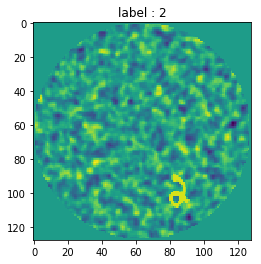

In [47]:
if True :
    print(index_image)
    plt.imshow(data3[index_image])
    print('shape',data3[:,:].shape)
    plt.title('label : '+str(label3[index_image].item()))

In [48]:
def affiche(donnees, titre, c_a, commentaire=None):
    if c_a :
        if commentaire :
            print(commentaire)
        plt.imshow(donnees)
        plt.title(titre)           
        plt.show()

def affiche_filtre(donnees, titre, c_a, r):
    if c_a :
        fig, ax = plt.subplots()
        plt.imshow(donnees)
        plt.title(titre)        
        rect = patches.Rectangle((args.N_pic//2-r, args.N_pic//2-r), 2*r, 2*r,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)            
        plt.show()

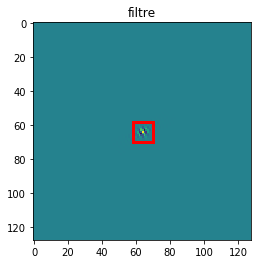

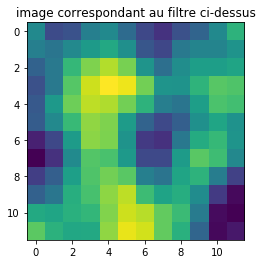

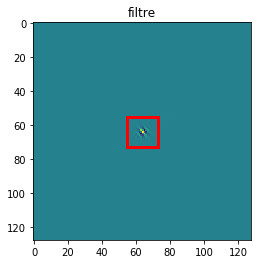

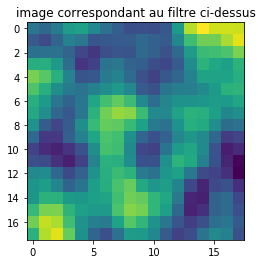

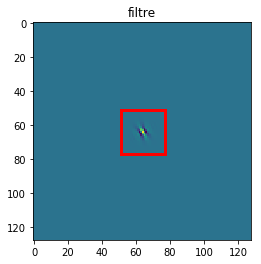

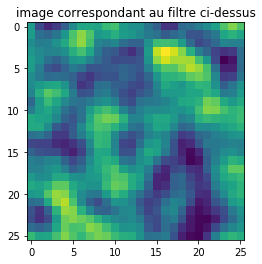

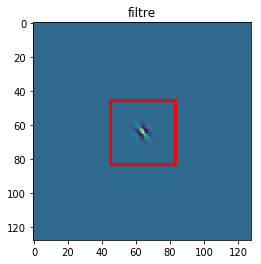

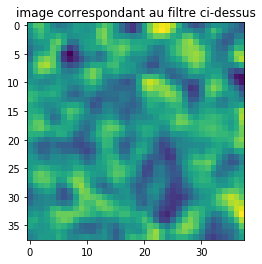

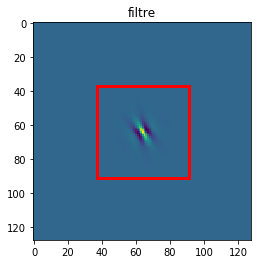

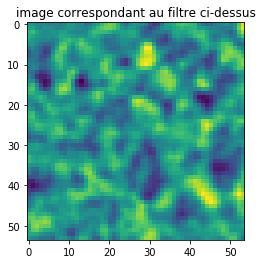

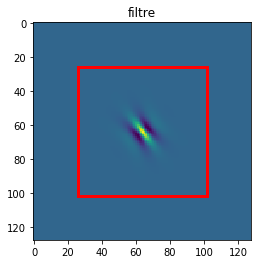

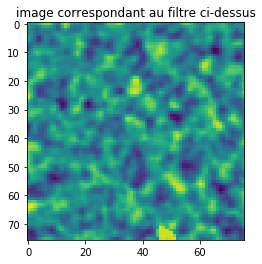

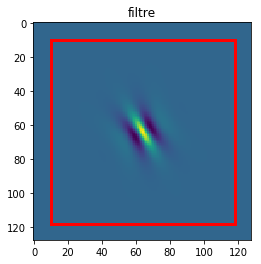

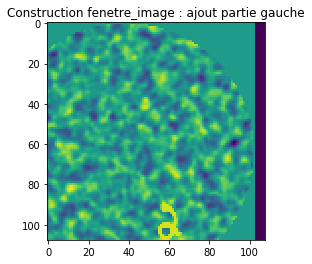

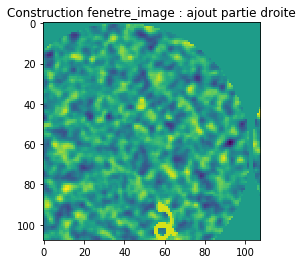

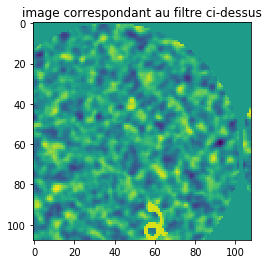

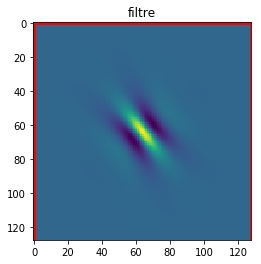

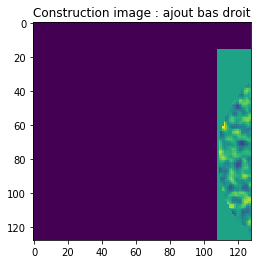

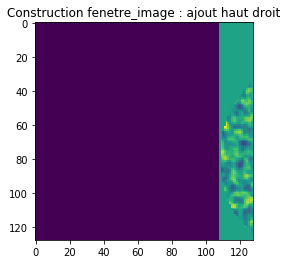

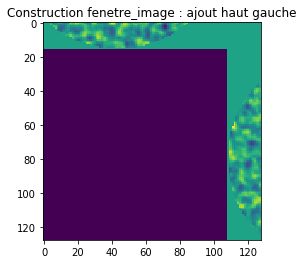

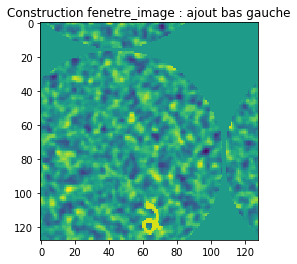

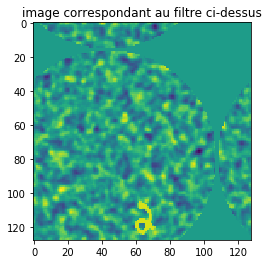

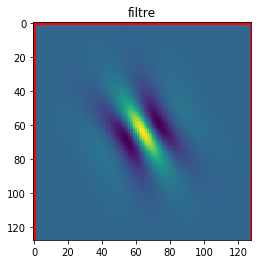

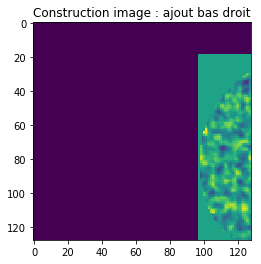

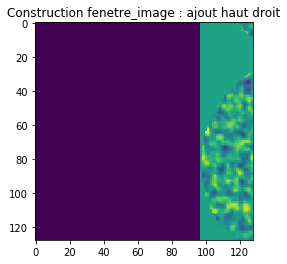

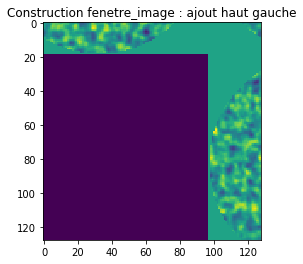

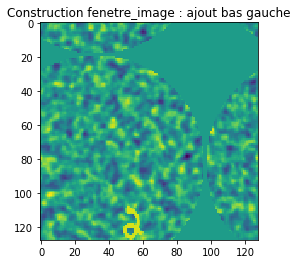

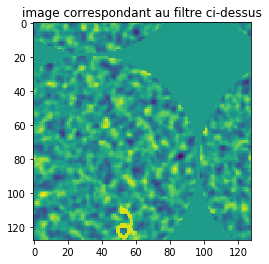

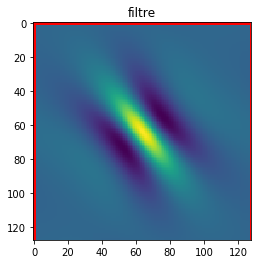

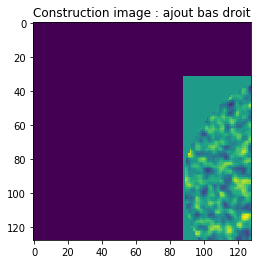

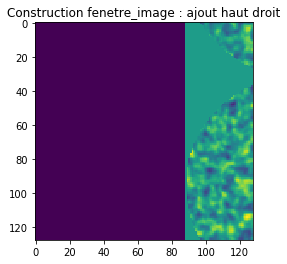

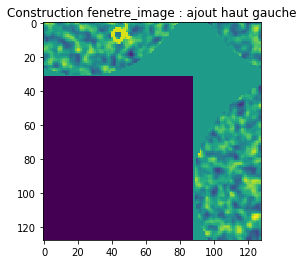

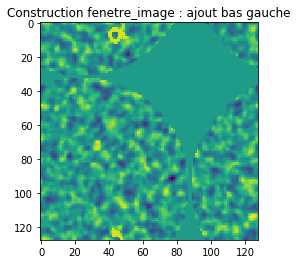

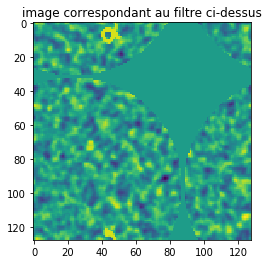

In [49]:
fullfield_dot_retina_dico = np.zeros(N_theta * N_azimuth * N_eccentricity * N_phase)

N_X, N_Y = args.N_pic, args.N_pic

indice = 0
for i_theta in range(N_theta):
    for i_azimuth in range(N_azimuth):
        for i_eccentricity in range(N_eccentricity):
            for i_phase in range(N_phase):
                #fullfield_dot_filters[indice] = np.ravel(retina_dico[i_theta][i_eccentricity][i_phase]) @ np.ravel(data_fullfield)
                                 
## les filtres sont centres
## il va falloir les décaler au bon endroit de l'image
                #filter = retina_dico[i_theta][i_phase][i_eccentricity] # a ne plus utiliser, azimuth est necessaire pour calculer des filtres corrects
                filter = retina_dico[i_theta][i_phase][i_eccentricity][i_azimuth]
                filter = filter.reshape((128, 128))
        
                ecc_max = .8
                ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
                psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
                x = int(N_X / 2 + r * np.cos(psi))
                y = int(N_Y / 2 + r * np.sin(psi))
                
# on reprend ensuite quasi tout le code de online_vectorizationVm

                c_a = i_azimuth == 8 and i_theta == 0 and i_phase == 0 # conditions d'affichage
                #c_a = False
                #print("conditions", c_a)

                #r = min(int(2*r), 64)
                r = min(int(3*r), 64)

                #filter -= np.mean(filter)
                affiche_filtre(filter, "filtre", c_a, r)
                
                #print(filter.shape)
                #print(filter)
                #print("type filter", type(filter))
                
                fenetre_filtre = filter[int(args.N_pic//2-r):int(args.N_pic//2+r),int(args.N_pic//2-r):int(args.N_pic//2+r)]
                fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]

                if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                    fenetre_image = np.zeros((2*r,2*r))


                    if y + r > args.N_pic : # ca depasse à droite
                        morceau_interne_fullfield = pixel_fullfield[x-r:x+r, y-r:args.N_pic]
                        morceau_externe_fullfield = pixel_fullfield[x-r:x+r, 0:y+r-args.N_pic] # qu'on est donc alle chercher ailleurs dans l'image
                        nb_lignes = morceau_externe_fullfield.shape[0]
                        if nb_lignes == 2*r : # ce n'est pas un coin
                            fenetre_image[0:2*r, 0:r+args.N_pic-y] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                            fenetre_image[0:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)

                        elif x - r < 0 : # contient le coin superieur droit
                            morceau_externe_fullfield = pixel_fullfield[0:x+r, 0:r-args.N_pic+y]
                            fenetre_image[r-x:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction image : ajout bas droit", c_a)
                            fenetre_image[0:r-x, r-y+args.N_pic:2*r] = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r-args.N_pic]
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)

                        elif x + r > args.N_pic : # contient le coin inferieur droit
                            fenetre_image[0:nb_lignes, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                            fenetre_image[r-x+args.N_pic:2*r, r-y+args.N_pic:2*r] = pixel_fullfield[0:x+r-args.N_pic, 0:y+r-args.N_pic]
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)


                    elif y - r < 0 : # ca depasse a gauche
                        morceau_externe_fullfield = pixel_fullfield[x-r:x+r, args.N_pic-r+y:args.N_pic]
                        morceau_interne_fullfield = pixel_fullfield[x-r:x+r, 0:y+r]
                        nb_lignes = morceau_externe_fullfield.shape[0]
                        if nb_lignes == 2*r : # ce n'est pas un coin
                            fenetre_image[0:2*r, 0:r-y] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                            fenetre_image[0:2*r, r-y:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)

                        elif x - r < 0 : # contient le coin superieur gauche
                            morceau_externe_fullfield = pixel_fullfield[0:x+r, args.N_pic-r+y:args.N_pic]
                            fenetre_image[r-x:2*r, 0:r-y] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                            fenetre_image[0:r-x, 0:r-y] = pixel_fullfield[args.N_pic-r+x:args.N_pic, args.N_pic-r+y:args.N_pic]
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)

                        elif x + r > args.N_pic : # contient le coin inferieur gauche
                            fenetre_image[r+args.N_pic-x:2*r, 0:r-y] = pixel_fullfield[0:x+r-args.N_pic, args.N_pic-r+y:args.N_pic]
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                            fenetre_image[0:r+args.N_pic-x, 0:r-y] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a) 


                    if x - r < 0 : # ca depasse en haut
                        morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, y-r:y+r]
                        morceau_interne_fullfield = pixel_fullfield[0:r+x, y-r:y+r]
                        nb_colonnes = morceau_externe_fullfield.shape[1]
                        if nb_colonnes == 2*r : # ce n'est pas un coin
                            fenetre_image[r-x:2*r, 0:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)
                            fenetre_image[0:r-x, 0:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)

                        elif y - r < 0 : # contient le coin superieur gauche
                            morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r]
                            morceau_interne_fullfield = pixel_fullfield[0:r+x, 0:y+r]
                            fenetre_image[0:r-x, r-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                            fenetre_image[r-x:2*r, r-y:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                        elif y + r > args.N_pic : # contient le coin superieur droit
                            nb_colonnes = r + args.N_pic - y 
                            fenetre_image[0:r-x, 0:nb_colonnes] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                            fenetre_image[r-x:2*r, 0:nb_colonnes] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)


                    elif x + r > args.N_pic : # ca depasse en bas
                        morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, y-r:y+r]
                        morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, y-r:y+r]
                        nb_colonnes = morceau_externe_fullfield.shape[1]
                        if nb_colonnes == 2*r : # ce n'est pas un coin                               
                            fenetre_image[0:args.N_pic-x+r, 0:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)
                            fenetre_image[args.N_pic-x+r:2*r, 0:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)

                        elif y - r < 0 : # contient le coin inferieur gauche
                            morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, 0:r+y]
                            morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, 0:r+y]
                            fenetre_image[0:args.N_pic-x+r, r-y:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                            fenetre_image[args.N_pic-x+r:2*r, r-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                        elif y + r > args.N_pic : # contient le coin inferieur droit
                            fenetre_image[0:args.N_pic-x+r, 0:nb_colonnes] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                            fenetre_image[args.N_pic-x+r:2*r, 0:nb_colonnes] = morceau_externe_fullfield 
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)


                affiche(fenetre_image, "image correspondant au filtre ci-dessus", c_a) 

                a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                fullfield_dot_retina_dico[indice] = a

                indice += 1


## Dico filtres tailles multiples

7
shape torch.Size([100, 128, 128])


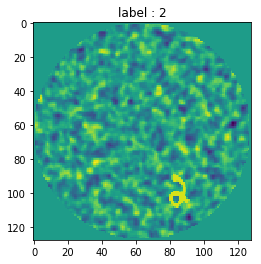

In [50]:
pixel_fullfield = data3[index_image]

if True :
    print(index_image)
    plt.imshow(data3[index_image])
    print('shape',data3[:,:].shape)
    plt.title('label : '+str(label3[index_image].item()))

In [51]:
from display import pe

In [52]:
N_theta=args.N_theta
N_azimuth=args.N_azimuth
N_eccentricity=args.N_eccentricity
N_phase=args.N_phase
print(N_theta, N_azimuth, N_eccentricity, N_phase)

6 24 10 2


In [53]:
def local_filter5(i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                 N_X=128, N_Y=128):
                 #rho=1.41, ecc_max=.8,
                 #sf_0_max=0.45, sf_0_r=0.03,
                 #B_sf=.4, B_theta=np.pi / 12): # on enleve self pour l'instant
                
    # !!?? Magic numbers !!??
    ecc_max = .8 # self.args.ecc_max
    sf_0_r = 0.03 # self.args.sf_0_r
    B_theta = np.pi/args.N_theta/2 #self.args.B_theta
    B_sf = .4
    sf_0_max = 0.45

    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    #print(r)
    dimension_filtre = min(2*int(2*r), 128) # 2*int(2*r) pour avoir des filtres vraiment de la meme taille qu'avant
    lg.set_size((dimension_filtre, dimension_filtre))
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi) # c'est bien le centre du filtre ?
    y = N_Y / 2 + r * np.sin(psi) # c'est bien le centre du filtre ?
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    #lg.show_loggabor(x, y, **params)
    #print('taille sortie', lg.loggabor(x, y, **params).ravel().shape)
    return lg.normalize(lg.invert(lg.loggabor(dimension_filtre//2, dimension_filtre//2, **params) * np.exp(-1j * phase)))

In [54]:
# Dico 4 entrees
if True :
    print("Creation du dictionnaire de filtres en cours")
    from LogGabor import LogGabor
    retina_dico ={}
    lg = LogGabor(pe=pe)
    for i_theta in range(N_theta) :
        retina_dico[i_theta] = {}
        for i_phase in range(N_phase) :
            retina_dico[i_theta][i_phase] = {}
            for i_eccentricity in range(N_eccentricity) :
                retina_dico[i_theta][i_phase][i_eccentricity] = {}
                for i_azimuth in range(N_azimuth):
                    retina_dico[i_theta][i_phase][i_eccentricity][i_azimuth] = np.ravel(local_filter5(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=128, N_Y=128))
    print("Dico cree")
    print(len(retina_dico),len(retina_dico[0]), len(retina_dico[0][0]), len(retina_dico[0][0][0]))
    print(len(retina_dico[0][0][0][0]))

Creation du dictionnaire de filtres en cours
Dico cree
6 2 10 24
64


In [55]:
def affiche(donnees, titre, c_a, commentaire=None):
    if c_a :
        if commentaire :
            print(commentaire)
        plt.imshow(donnees)
        plt.title(titre)           
        plt.show()

def affiche_filtre(donnees, titre, c_a, r):
    if c_a :
        plt.imshow(donnees)
        plt.title(titre)           
        plt.show()

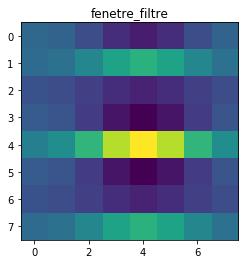

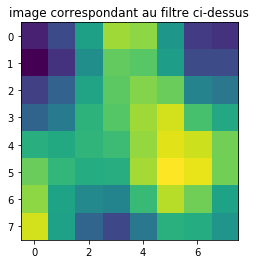

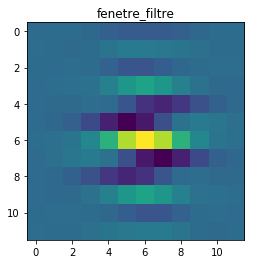

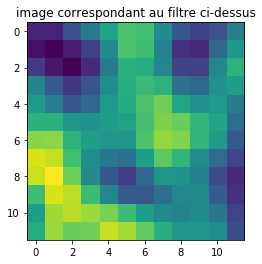

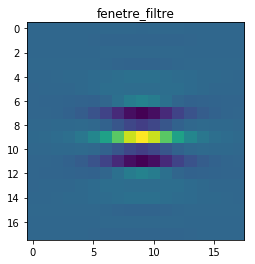

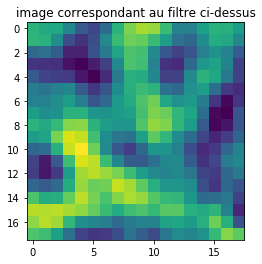

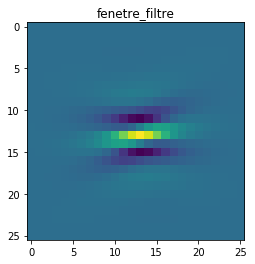

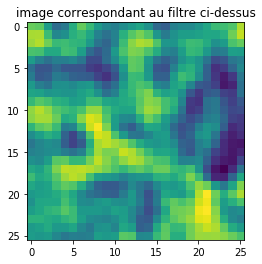

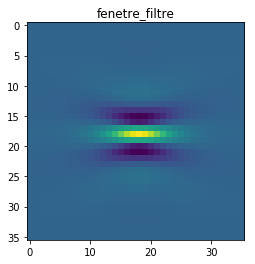

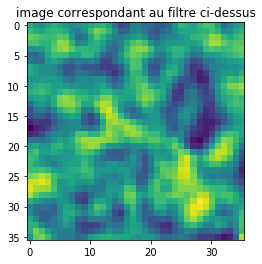

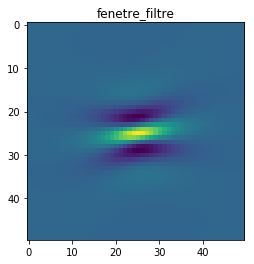

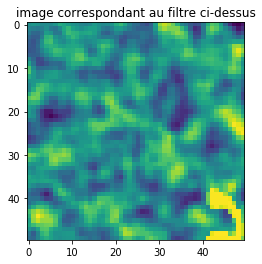

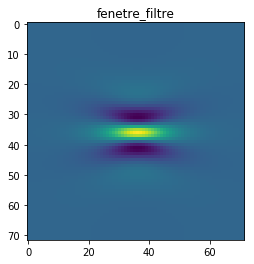

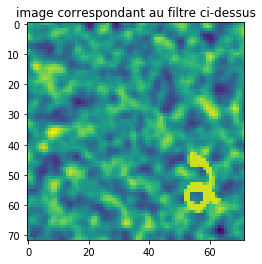

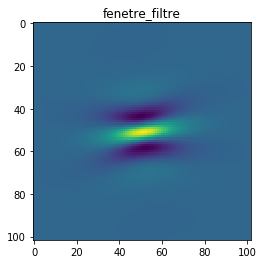

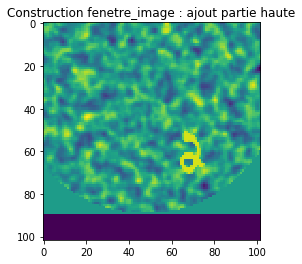

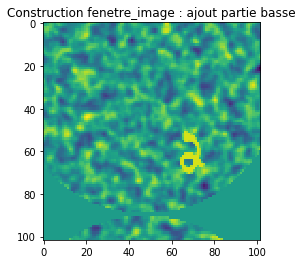

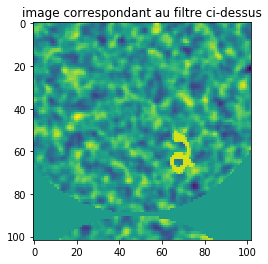

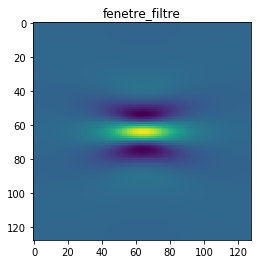

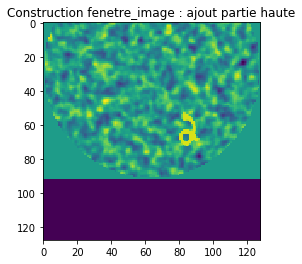

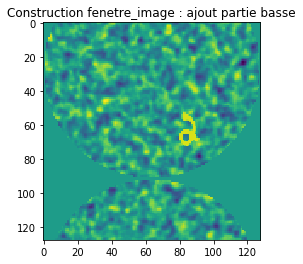

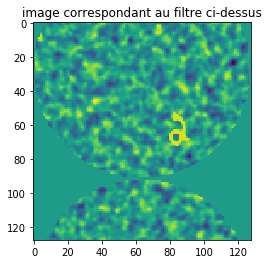

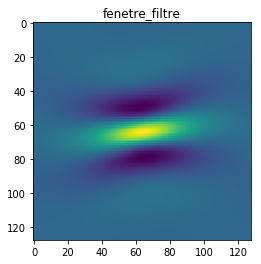

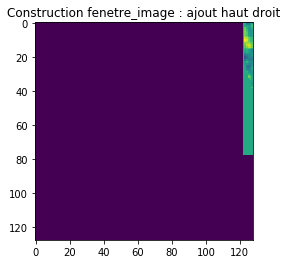

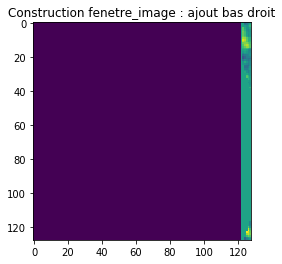

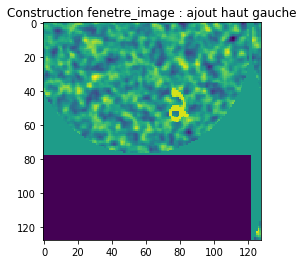

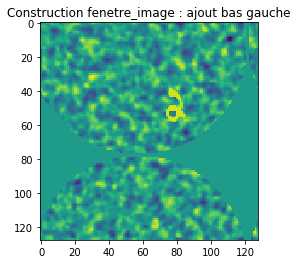

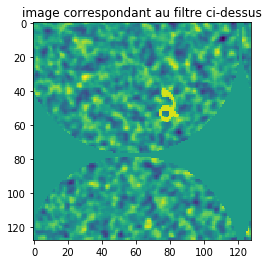

In [56]:
fullfield_dot_retina_dico = np.zeros(N_theta * N_azimuth * N_eccentricity * N_phase)

N_X, N_Y = args.N_pic, args.N_pic

indice = 0
for i_theta in range(N_theta):
    for i_azimuth in range(N_azimuth):
        for i_eccentricity in range(N_eccentricity):
            for i_phase in range(N_phase):

                fenetre_filtre = retina_dico[i_theta][i_phase][i_eccentricity][i_azimuth]
                dimension_filtre = int(fenetre_filtre.shape[0]**(1/2))
                fenetre_filtre = fenetre_filtre.reshape((dimension_filtre, dimension_filtre))
                # fenetre filtre correspond au filtre calcule "entier"
        
                ecc_max = .8
                ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
                psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
                x = int(N_X / 2 + r * np.cos(psi))
                y = int(N_Y / 2 + r * np.sin(psi))
                r = int(r)
                
                #print("x, y, r", x, y, r)
                #print("2r", 2*r)
                #print("dim filtre", dimension_filtre)
                
                r = dimension_filtre//2
                
# on reprend ensuite quasi tout le code de online_vectorizationVm

                c_a = i_azimuth == 0 and i_theta == 0 and i_phase == 0 # conditions d'affichage
                #c_a = False
                #print("conditions", c_a)
                
                #print("taille fenetre_filtre", fenetre_filtre.shape)
                affiche_filtre(fenetre_filtre, "fenetre_filtre", c_a, r)
                
                fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]

                if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                    fenetre_image = np.zeros((dimension_filtre,dimension_filtre))


                    if y + r > args.N_pic : # ca depasse à droite
                        morceau_interne_fullfield = pixel_fullfield[x-r:x+r, y-r:args.N_pic]
                        morceau_externe_fullfield = pixel_fullfield[x-r:x+r, 0:y+r-args.N_pic] # qu'on est donc alle chercher ailleurs dans l'image
                        nb_lignes = morceau_externe_fullfield.shape[0]
                        if nb_lignes == 2*r : # ce n'est pas un coin
                            fenetre_image[0:2*r, 0:r+args.N_pic-y] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                            fenetre_image[0:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)

                        elif x - r < 0 : # contient le coin superieur droit
                            morceau_externe_fullfield = pixel_fullfield[0:x+r, 0:r-args.N_pic+y]
                            fenetre_image[r-x:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction image : ajout bas droit", c_a)
                            fenetre_image[0:r-x, r-y+args.N_pic:2*r] = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r-args.N_pic]
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)

                        elif x + r > args.N_pic : # contient le coin inferieur droit
                            fenetre_image[0:nb_lignes, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                            fenetre_image[r-x+args.N_pic:2*r, r-y+args.N_pic:2*r] = pixel_fullfield[0:x+r-args.N_pic, 0:y+r-args.N_pic]
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)


                    elif y - r < 0 : # ca depasse a gauche
                        morceau_externe_fullfield = pixel_fullfield[x-r:x+r, args.N_pic-r+y:args.N_pic]
                        morceau_interne_fullfield = pixel_fullfield[x-r:x+r, 0:y+r]
                        nb_lignes = morceau_externe_fullfield.shape[0]
                        if nb_lignes == 2*r : # ce n'est pas un coin
                            fenetre_image[0:2*r, 0:r-y] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                            fenetre_image[0:2*r, r-y:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)

                        elif x - r < 0 : # contient le coin superieur gauche
                            morceau_externe_fullfield = pixel_fullfield[0:x+r, args.N_pic-r+y:args.N_pic]
                            fenetre_image[r-x:2*r, 0:r-y] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                            fenetre_image[0:r-x, 0:r-y] = pixel_fullfield[args.N_pic-r+x:args.N_pic, args.N_pic-r+y:args.N_pic]
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)

                        elif x + r > args.N_pic : # contient le coin inferieur gauche
                            fenetre_image[r+args.N_pic-x:2*r, 0:r-y] = pixel_fullfield[0:x+r-args.N_pic, args.N_pic-r+y:args.N_pic]
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                            fenetre_image[0:r+args.N_pic-x, 0:r-y] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a) 


                    if x - r < 0 : # ca depasse en haut
                        morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, y-r:y+r]
                        morceau_interne_fullfield = pixel_fullfield[0:r+x, y-r:y+r]
                        nb_colonnes = morceau_externe_fullfield.shape[1]
                        if nb_colonnes == 2*r : # ce n'est pas un coin
                            fenetre_image[r-x:2*r, 0:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)
                            fenetre_image[0:r-x, 0:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)

                        elif y - r < 0 : # contient le coin superieur gauche
                            morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r]
                            morceau_interne_fullfield = pixel_fullfield[0:r+x, 0:y+r]
                            fenetre_image[0:r-x, r-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                            fenetre_image[r-x:2*r, r-y:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                        elif y + r > args.N_pic : # contient le coin superieur droit
                            nb_colonnes = r + args.N_pic - y 
                            fenetre_image[0:r-x, 0:nb_colonnes] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                            fenetre_image[r-x:2*r, 0:nb_colonnes] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)


                    elif x + r > args.N_pic : # ca depasse en bas
                        morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, y-r:y+r]
                        morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, y-r:y+r]
                        nb_colonnes = morceau_externe_fullfield.shape[1]
                        if nb_colonnes == 2*r : # ce n'est pas un coin   
                            #print("morceau_interne_fullfield", morceau_interne_fullfield.shape)
                            #print("fenetre_image", fenetre_image[0:args.N_pic-x+r, 0:2*r].shape)
                            fenetre_image[0:args.N_pic-x+r, 0:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)
                            fenetre_image[args.N_pic-x+r:2*r, 0:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)

                        elif y - r < 0 : # contient le coin inferieur gauche
                            morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, 0:r+y]
                            morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, 0:r+y]
                            fenetre_image[0:args.N_pic-x+r, r-y:2*r] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                            fenetre_image[args.N_pic-x+r:2*r, r-y:2*r] = morceau_externe_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                        elif y + r > args.N_pic : # contient le coin inferieur droit
                            fenetre_image[0:args.N_pic-x+r, 0:nb_colonnes] = morceau_interne_fullfield
                            affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                            fenetre_image[args.N_pic-x+r:2*r, 0:nb_colonnes] = morceau_externe_fullfield 
                            affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)


                affiche(fenetre_image, "image correspondant au filtre ci-dessus", c_a) 

                a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                fullfield_dot_retina_dico[indice] = a

                indice += 1


In [57]:
diff = 0
for i in range(2880):
    diff += abs(fullfield_dot_filtersVm[i] - fullfield_dot_retina_dico[i])
    #if i%10 ==0 : print(i,abs(fullfield_dot_filters[i] - fullfield_dot_filtersV[i]))
print(diff)

84.04305026875245


(-25, 25)

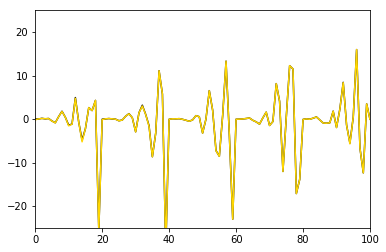

In [58]:
plt.plot(fullfield_dot_filtersVm, 'black')
plt.plot(fullfield_dot_retina_dico, 'gold')

axes = plt.gca()
axes.set_xlim(0,100)
axes.set_ylim(-25,25)

## Comparaison temps d'exécution

In [59]:
import datetime

7
shape torch.Size([100, 128, 128])


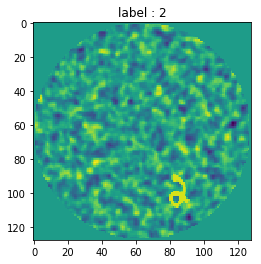

In [60]:
pixel_fullfield = data3[index_image]

if True :
    print(index_image)
    plt.imshow(data3[index_image])
    print('shape',data3[:,:].shape)
    plt.title('label : '+str(label3[index_image].item()))

#### Code original

In [61]:
debut = datetime.datetime.now()



from display import pe

def local_filter(i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                 N_X=128, N_Y=128):
                 #rho=1.41, ecc_max=.8,
                 #sf_0_max=0.45, sf_0_r=0.03,
                 #B_sf=.4, B_theta=np.pi / 12):

    # !!?? Magic numbers !!??
    ecc_max = .8 # self.args.ecc_max
    sf_0_r = 0.03 # self.args.sf_0_r
    B_theta = np.pi/args.N_theta/2 #self.args.B_theta
    B_sf = .4
    sf_0_max = 0.45

    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi)
    y = N_Y / 2 + r * np.sin(psi)
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    return lg.normalize(lg.invert(lg.loggabor(x, y, **params) * np.exp(-1j * phase))).ravel()

def vectorization():
    #N_theta=6, N_azimuth=16, N_eccentricity=10, N_phase=2,
    #              N_X=128, N_Y=128, rho=1.41, ecc_max=.8, sf_0_max=0.45, sf_0_r=0.03, B_sf=.4, B_theta=np.pi / 12):

    retina = np.zeros((args.N_theta, args.N_azimuth, args.N_eccentricity, args.N_phase, args.N_pic**2))

    from LogGabor import LogGabor
    lg = LogGabor(pe=pe)
    lg.set_size((args.N_pic, args.N_pic))

    for i_theta in range(args.N_theta):
        for i_azimuth in range(args.N_azimuth):
            for i_eccentricity in range(args.N_eccentricity):
                for i_phase in range(args.N_phase):
                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = local_filter(i_theta,
                                                                                          i_azimuth,
                                                                                          i_eccentricity,
                                                                                          i_phase,
                                                                                          lg,
                                                                                          N_X=args.N_pic,
                                                                                          N_Y=args.N_pic)
                                                                                          #rho=self.args.rho,
                                                                                          #ecc_max=self.args.ecc_max,
                                                                                          #sf_0_max=self.args.sf_0_max,
                                                                                          #sf_0_r=self.args.sf_0_r,
                                                                                          #B_sf=self.args.B_sf,
                                                                                          #B_theta=self.args.B_theta)
    return retina





data_fullfield = pixel_fullfield
retina_transform = vectorization()
feature_vector_size = args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase
retina_transform_vector = retina_transform.reshape((feature_vector_size, args.N_pic ** 2))
data_retina = retina_transform_vector @ np.ravel(data_fullfield)


fullfield_dot_filters = data_retina

fin = datetime.datetime.now()
print("Duree d'execution pour : ", fin-debut)

Duree d'execution pour :  0:00:09.765617


#### Code vectorization Vm

In [62]:
debut = datetime.datetime.now()

import matplotlib.patches as patches
from display import pe

## Completion image avec des vraies valeurs, "modulo"

def affiche(donnees, titre, c_a, commentaire=None):
    if c_a :
        if commentaire :
            print(commentaire)
        plt.imshow(donnees)
        plt.title(titre)           
        plt.show()

def affiche_filtre(donnees, titre, c_a, r):
    if c_a :
        fig, ax = plt.subplots()
        plt.imshow(donnees)
        plt.title(titre)        
        rect = patches.Rectangle((args.N_pic//2-r, args.N_pic//2-r), 2*r, 2*r,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)            
        plt.show()
        
def local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                 N_X=128, N_Y=128):
                 #rho=1.41, ecc_max=.8,
                 #sf_0_max=0.45, sf_0_r=0.03,
                 #B_sf=.4, B_theta=np.pi / 12): # on enleve self pour l'instant

    # !!?? Magic numbers !!??
    ecc_max = .8 # self.args.ecc_max
    sf_0_r = 0.03 # self.args.sf_0_r
    B_theta = np.pi/args.N_theta/2 #self.args.B_theta
    B_sf = .4
    sf_0_max = 0.45

    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    #print(r)
    size = int(2*r)
    if size < 2 :
        size = 2    
    #print("size",size)
    #lg.set_size((size, size))
    lg.set_size((N_X, N_Y))
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi) # c'est bien le centre du filtre ?
    y = N_Y / 2 + r * np.sin(psi) # c'est bien le centre du filtre ?
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    #lg.show_loggabor(x, y, **params)
    #print('taille sortie', lg.loggabor(x, y, **params).ravel().shape)
    return lg.normalize(lg.invert(lg.loggabor(N_X//2, N_Y//2, **params) * np.exp(-1j * phase))), size, int(x), int(y), r

def online_vectorizationVm(pixel_fullfield):   # pixel_fullfield = image # on enleve self pour l'instant
    fullfield_dot_filters = np.zeros(args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase)

    from LogGabor import LogGabor
    lg = LogGabor(pe=pe)
        
    indice = 0 
    for i_theta in range(args.N_theta):
        for i_azimuth in range(args.N_azimuth):
            for i_eccentricity in range(args.N_eccentricity):
                for i_phase in range(args.N_phase):
                    filter, size, x, y, r = local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic,
                                              N_Y=args.N_pic)
                    
                    c_a = i_azimuth == 16 and i_theta == 0 and i_phase == 0 # conditions d'affichage
                    c_a = False
                    #print("conditions", c_a)
                    
                    r = min(int(2*r), 64)
                    #r = min(int(3*r), 64)

                    #filter -= np.mean(filter)
                    affiche_filtre(filter, "filtre", c_a, r)
                    
                    fenetre_filtre = filter[int(args.N_pic//2-r):int(args.N_pic//2+r),int(args.N_pic//2-r):int(args.N_pic//2+r)]
                    fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]
                    #print("taille fenetre filtre", fenetre_filtre.shape)

                    if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                        fenetre_image = np.zeros((2*r,2*r))

                        
                        if y + r > args.N_pic : # ca depasse à droite
                            morceau_interne_fullfield = pixel_fullfield[x-r:x+r, y-r:args.N_pic]
                            morceau_externe_fullfield = pixel_fullfield[x-r:x+r, 0:y+r-args.N_pic] # qu'on est donc alle chercher ailleurs dans l'image
                            nb_lignes = morceau_externe_fullfield.shape[0]
                            if nb_lignes == 2*r : # ce n'est pas un coin
                                fenetre_image[0:2*r, 0:r+args.N_pic-y] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                                fenetre_image[0:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)

                            elif x - r < 0 : # contient le coin superieur droit
                                morceau_externe_fullfield = pixel_fullfield[0:x+r, 0:r-args.N_pic+y]
                                fenetre_image[r-x:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction image : ajout bas droit", c_a)
                                fenetre_image[0:r-x, r-y+args.N_pic:2*r] = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r-args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)

                            elif x + r > args.N_pic : # contient le coin inferieur droit
                                fenetre_image[0:nb_lignes, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                                fenetre_image[r-x+args.N_pic:2*r, r-y+args.N_pic:2*r] = pixel_fullfield[0:x+r-args.N_pic, 0:y+r-args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)
               
                
                        elif y - r < 0 : # ca depasse a gauche
                            morceau_externe_fullfield = pixel_fullfield[x-r:x+r, args.N_pic-r+y:args.N_pic]
                            morceau_interne_fullfield = pixel_fullfield[x-r:x+r, 0:y+r]
                            nb_lignes = morceau_externe_fullfield.shape[0]
                            if nb_lignes == 2*r : # ce n'est pas un coin
                                fenetre_image[0:2*r, 0:r-y] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                                fenetre_image[0:2*r, r-y:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)
                                
                            elif x - r < 0 : # contient le coin superieur gauche
                                morceau_externe_fullfield = pixel_fullfield[0:x+r, args.N_pic-r+y:args.N_pic]
                                fenetre_image[r-x:2*r, 0:r-y] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                                fenetre_image[0:r-x, 0:r-y] = pixel_fullfield[args.N_pic-r+x:args.N_pic, args.N_pic-r+y:args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)

                            elif x + r > args.N_pic : # contient le coin inferieur gauche
                                fenetre_image[r+args.N_pic-x:2*r, 0:r-y] = pixel_fullfield[0:x+r-args.N_pic, args.N_pic-r+y:args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                                fenetre_image[0:r+args.N_pic-x, 0:r-y] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a) 

                            
                        if x - r < 0 : # ca depasse en haut
                            morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, y-r:y+r]
                            morceau_interne_fullfield = pixel_fullfield[0:r+x, y-r:y+r]
                            nb_colonnes = morceau_externe_fullfield.shape[1]
                            if nb_colonnes == 2*r : # ce n'est pas un coin
                                fenetre_image[r-x:2*r, 0:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)
                                fenetre_image[0:r-x, 0:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)

                            elif y - r < 0 : # contient le coin superieur gauche
                                morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r]
                                morceau_interne_fullfield = pixel_fullfield[0:r+x, 0:y+r]
                                fenetre_image[0:r-x, r-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                                fenetre_image[r-x:2*r, r-y:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                            elif y + r > args.N_pic : # contient le coin superieur droit
                                nb_colonnes = r + args.N_pic - y 
                                fenetre_image[0:r-x, 0:nb_colonnes] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                                fenetre_image[r-x:2*r, 0:nb_colonnes] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                            

                        elif x + r > args.N_pic : # ca depasse en bas
                            morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, y-r:y+r]
                            morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, y-r:y+r]
                            nb_colonnes = morceau_externe_fullfield.shape[1]
                            if nb_colonnes == 2*r : # ce n'est pas un coin                               
                                fenetre_image[0:args.N_pic-x+r, 0:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)
                                fenetre_image[args.N_pic-x+r:2*r, 0:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)

                            elif y - r < 0 : # contient le coin inferieur gauche
                                morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, 0:r+y]
                                morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, 0:r+y]
                                fenetre_image[0:args.N_pic-x+r, r-y:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                                fenetre_image[args.N_pic-x+r:2*r, r-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                            elif y + r > args.N_pic : # contient le coin inferieur droit
                                fenetre_image[0:args.N_pic-x+r, 0:nb_colonnes] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                                fenetre_image[args.N_pic-x+r:2*r, 0:nb_colonnes] = morceau_externe_fullfield 
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                            
                    
                    affiche(fenetre_image, "image correspondant au filtre ci-dessus", c_a) 
                        
                    a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                    fullfield_dot_filters[indice] = a
                    
                    indice += 1

    return fullfield_dot_filters

fullfield_dot_filtersVm = online_vectorizationVm(pixel_fullfield)

fin = datetime.datetime.now()
print("Duree d'execution : ", fin-debut)


Duree d'execution :  0:00:27.690049


#### Code vectorization dico

In [63]:
from display import pe

N_theta=args.N_theta
N_azimuth=args.N_azimuth
N_eccentricity=args.N_eccentricity
N_phase=args.N_phase

def local_filter5(i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                 N_X=128, N_Y=128):
                 #rho=1.41, ecc_max=.8,
                 #sf_0_max=0.45, sf_0_r=0.03,
                 #B_sf=.4, B_theta=np.pi / 12): # on enleve self pour l'instant
                
    # !!?? Magic numbers !!??
    ecc_max = .8 # self.args.ecc_max
    sf_0_r = 0.03 # self.args.sf_0_r
    B_theta = np.pi/args.N_theta/2 #self.args.B_theta
    B_sf = .4
    sf_0_max = 0.45

    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    #print(r)
    dimension_filtre = min(2*int(2*r), 128) # 2*int(2*r) pour avoir des filtres vraiment de la meme taille qu'avant
    lg.set_size((dimension_filtre, dimension_filtre))
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi) # c'est bien le centre du filtre ?
    y = N_Y / 2 + r * np.sin(psi) # c'est bien le centre du filtre ?
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    #lg.show_loggabor(x, y, **params)
    #print('taille sortie', lg.loggabor(x, y, **params).ravel().shape)
    return lg.normalize(lg.invert(lg.loggabor(dimension_filtre//2, dimension_filtre//2, **params) * np.exp(-1j * phase)))


# Dico 4 entrees
def initialisation_dico():
    print("Creation du dictionnaire de filtres en cours")
    from LogGabor import LogGabor
    retina_dico ={}
    lg = LogGabor(pe=pe)
    for i_theta in range(N_theta) :
        retina_dico[i_theta] = {}
        for i_phase in range(N_phase) :
            retina_dico[i_theta][i_phase] = {}
            for i_eccentricity in range(N_eccentricity) :
                retina_dico[i_theta][i_phase][i_eccentricity] = {}
                for i_azimuth in range(N_azimuth):
                    retina_dico[i_theta][i_phase][i_eccentricity][i_azimuth] = np.ravel(local_filter5(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=128, N_Y=128))
    print("Dico cree")
    #print(len(retina_dico),len(retina_dico[0]), len(retina_dico[0][0]), len(retina_dico[0][0][0]))
    #print(len(retina_dico[0][0][0][0]))
    return retina_dico

retina_dico = initialisation_dico()


debut = datetime.datetime.now()


def affiche(donnees, titre, c_a, commentaire=None):
    if c_a :
        if commentaire :
            print(commentaire)
        plt.imshow(donnees)
        plt.title(titre)           
        plt.show()

def affiche_filtre(donnees, titre, c_a, r):
    if c_a :
        plt.imshow(donnees)
        plt.title(titre)           
        plt.show()
        
def online_vectorization_dico(pixel_fullfield):
    fullfield_dot_retina_dico = np.zeros(N_theta * N_azimuth * N_eccentricity * N_phase)

    N_X, N_Y = args.N_pic, args.N_pic
    

    indice = 0
    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                for i_phase in range(N_phase):

                    fenetre_filtre = retina_dico[i_theta][i_phase][i_eccentricity][i_azimuth]
                    dimension_filtre = int(fenetre_filtre.shape[0]**(1/2))
                    fenetre_filtre = fenetre_filtre.reshape((dimension_filtre, dimension_filtre))
                    # fenetre filtre correspond au filtre calcule "entier"

                    ecc_max = .8
                    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
                    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
                    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
                    x = int(N_X / 2 + r * np.cos(psi))
                    y = int(N_Y / 2 + r * np.sin(psi))
                    r = int(r)

                    #print("x, y, r", x, y, r)
                    #print("2r", 2*r)
                    #print("dim filtre", dimension_filtre)

                    r = dimension_filtre//2

    # on reprend ensuite quasi tout le code de online_vectorizationVm

                    c_a = i_azimuth == 0 and i_theta == 0 and i_phase == 0 # conditions d'affichage
                    c_a = False
                    #print("conditions", c_a)

                    #print("taille fenetre_filtre", fenetre_filtre.shape)
                    affiche_filtre(fenetre_filtre, "fenetre_filtre", c_a, r)

                    fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]

                    if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                        fenetre_image = np.zeros((dimension_filtre,dimension_filtre))


                        if y + r > args.N_pic : # ca depasse à droite
                            morceau_interne_fullfield = pixel_fullfield[x-r:x+r, y-r:args.N_pic]
                            morceau_externe_fullfield = pixel_fullfield[x-r:x+r, 0:y+r-args.N_pic] # qu'on est donc alle chercher ailleurs dans l'image
                            nb_lignes = morceau_externe_fullfield.shape[0]
                            if nb_lignes == 2*r : # ce n'est pas un coin
                                fenetre_image[0:2*r, 0:r+args.N_pic-y] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                                fenetre_image[0:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)

                            elif x - r < 0 : # contient le coin superieur droit
                                morceau_externe_fullfield = pixel_fullfield[0:x+r, 0:r-args.N_pic+y]
                                fenetre_image[r-x:2*r, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction image : ajout bas droit", c_a)
                                fenetre_image[0:r-x, r-y+args.N_pic:2*r] = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r-args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)

                            elif x + r > args.N_pic : # contient le coin inferieur droit
                                fenetre_image[0:nb_lignes, r+args.N_pic-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                                fenetre_image[r-x+args.N_pic:2*r, r-y+args.N_pic:2*r] = pixel_fullfield[0:x+r-args.N_pic, 0:y+r-args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)


                        elif y - r < 0 : # ca depasse a gauche
                            morceau_externe_fullfield = pixel_fullfield[x-r:x+r, args.N_pic-r+y:args.N_pic]
                            morceau_interne_fullfield = pixel_fullfield[x-r:x+r, 0:y+r]
                            nb_lignes = morceau_externe_fullfield.shape[0]
                            if nb_lignes == 2*r : # ce n'est pas un coin
                                fenetre_image[0:2*r, 0:r-y] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie gauche", c_a)
                                fenetre_image[0:2*r, r-y:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie droite", c_a)

                            elif x - r < 0 : # contient le coin superieur gauche
                                morceau_externe_fullfield = pixel_fullfield[0:x+r, args.N_pic-r+y:args.N_pic]
                                fenetre_image[r-x:2*r, 0:r-y] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                                fenetre_image[0:r-x, 0:r-y] = pixel_fullfield[args.N_pic-r+x:args.N_pic, args.N_pic-r+y:args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)

                            elif x + r > args.N_pic : # contient le coin inferieur gauche
                                fenetre_image[r+args.N_pic-x:2*r, 0:r-y] = pixel_fullfield[0:x+r-args.N_pic, args.N_pic-r+y:args.N_pic]
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)
                                fenetre_image[0:r+args.N_pic-x, 0:r-y] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a) 


                        if x - r < 0 : # ca depasse en haut
                            morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, y-r:y+r]
                            morceau_interne_fullfield = pixel_fullfield[0:r+x, y-r:y+r]
                            nb_colonnes = morceau_externe_fullfield.shape[1]
                            if nb_colonnes == 2*r : # ce n'est pas un coin
                                fenetre_image[r-x:2*r, 0:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)
                                fenetre_image[0:r-x, 0:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)

                            elif y - r < 0 : # contient le coin superieur gauche
                                morceau_externe_fullfield = pixel_fullfield[args.N_pic-r+x:args.N_pic, 0:y+r]
                                morceau_interne_fullfield = pixel_fullfield[0:r+x, 0:y+r]
                                fenetre_image[0:r-x, r-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                                fenetre_image[r-x:2*r, r-y:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                            elif y + r > args.N_pic : # contient le coin superieur droit
                                nb_colonnes = r + args.N_pic - y 
                                fenetre_image[0:r-x, 0:nb_colonnes] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                                fenetre_image[r-x:2*r, 0:nb_colonnes] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)


                        elif x + r > args.N_pic : # ca depasse en bas
                            morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, y-r:y+r]
                            morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, y-r:y+r]
                            nb_colonnes = morceau_externe_fullfield.shape[1]
                            if nb_colonnes == 2*r : # ce n'est pas un coin   
                                #print("morceau_interne_fullfield", morceau_interne_fullfield.shape)
                                #print("fenetre_image", fenetre_image[0:args.N_pic-x+r, 0:2*r].shape)
                                fenetre_image[0:args.N_pic-x+r, 0:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie haute", c_a)
                                fenetre_image[args.N_pic-x+r:2*r, 0:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout partie basse", c_a)

                            elif y - r < 0 : # contient le coin inferieur gauche
                                morceau_interne_fullfield = pixel_fullfield[x-r:args.N_pic, 0:r+y]
                                morceau_externe_fullfield = pixel_fullfield[0:r-args.N_pic+x, 0:r+y]
                                fenetre_image[0:args.N_pic-x+r, r-y:2*r] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut droit", c_a)
                                fenetre_image[args.N_pic-x+r:2*r, r-y:2*r] = morceau_externe_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas droit", c_a)

                            elif y + r > args.N_pic : # contient le coin inferieur droit
                                fenetre_image[0:args.N_pic-x+r, 0:nb_colonnes] = morceau_interne_fullfield
                                affiche(fenetre_image, "Construction fenetre_image : ajout haut gauche", c_a)
                                fenetre_image[args.N_pic-x+r:2*r, 0:nb_colonnes] = morceau_externe_fullfield 
                                affiche(fenetre_image, "Construction fenetre_image : ajout bas gauche", c_a)


                    affiche(fenetre_image, "image correspondant au filtre ci-dessus", c_a) 

                    a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                    fullfield_dot_retina_dico[indice] = a

                    indice += 1
    
    return fullfield_dot_retina_dico
    

fullfield_dot_filters_dico = online_vectorization_dico(pixel_fullfield)                    
                    
fin = datetime.datetime.now()
print("Duree d'execution : ", fin-debut)

Creation du dictionnaire de filtres en cours
Dico cree
Duree d'execution :  0:00:00.249601


#### Comparaison des fullfield_dot_filters

(-25, 25)

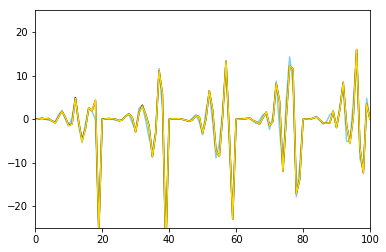

In [64]:
plt.plot(fullfield_dot_filters, color='skyblue')
plt.plot(fullfield_dot_filtersVm, color='black')
plt.plot(fullfield_dot_filters_dico, color='gold')

axes = plt.gca()
axes.set_xlim(0,100)
axes.set_ylim(-25,25)

In [65]:
diff_original_Vm = 0
diff_original_dico = 0
diff_Vm_dico = 0
for i in range(2880):
    diff_original_Vm = abs(fullfield_dot_filters[i]-fullfield_dot_filtersVm[i])
    diff_original_dico = abs(fullfield_dot_filters[i]-fullfield_dot_filters_dico[i])
    diff_Vm_dico = abs(fullfield_dot_filtersVm[i]-fullfield_dot_filters_dico[i])
print("diff_original_Vm", diff_original_Vm)
print("diff_original_dico", diff_original_dico)
print("diff_Vm_dico", diff_Vm_dico)

diff_original_Vm 0.6550364033784266
diff_original_dico 0.6550364033784266
diff_Vm_dico 0.0


## Ajout de dico_transform (online_vectorization_dico) à retina_copie + tests

Voir le jupyter Notebook 2019-07-01_Marion_Tests_dico_transform_(cf_retina_copie)